# Stock Price Forecasting Using SARIMA & Prophet


Actionable Decision : Whether to Invest or Not in the Stock

In [ ]:
conda install -c conda-forge fbprophet

In [1]:
#packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from scipy import stats 
from statsmodels.graphics.gofplots import qqplot as qq
from scipy.stats import kurtosis
import scipy
from statsmodels.tsa.stattools import adfuller
from pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pandas.core.window.rolling import Rolling
from sklearn.model_selection import train_test_split as split
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import warnings
import itertools
warnings.filterwarnings("ignore")
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error
from sklearn.model_selection import KFold, ShuffleSplit, StratifiedKFold, StratifiedShuffleSplit, TimeSeriesSplit
from fbprophet import Prophet
from IPython import display
from matplotlib import pyplot as plt
import os
import re
from colorama import Fore, Back, Style
import seaborn as sns
import plotly.express as px
import warnings
from matplotlib.patches import Patch

In [2]:
## Matplotlib Parameters
import matplotlib.ticker as ticker
rcParams['axes.labelsize'] = 12
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
plt.style.context('fivethirtyeight')

## Loading Data

In [3]:
data=pd.read_csv('HDFCBANK.NS.csv')

In [4]:
##Summary Statistics
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-09-03,298.774994,298.899994,294.000000,295.225006,275.351074,3718908.0
1,2012-09-04,295.274994,296.174988,293.600006,295.049988,275.187897,2886294.0
2,2012-09-05,294.000000,298.000000,293.674988,296.049988,276.120544,6079236.0
3,2012-09-06,295.049988,296.750000,293.049988,294.075012,274.278534,2548726.0
4,2012-09-07,297.125000,297.500000,292.850006,295.200012,275.327820,5602574.0


In [5]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2462.000000,2462.000000,2462.000000,2462.000000,2462.000000,2.462000e+03
mean,852.378097,860.309463,843.630606,852.173995,830.320045,6.134032e+06
std,408.231976,412.100590,403.913101,407.965284,409.534964,6.500082e+06
min,277.850006,286.000000,252.524994,280.950012,264.225830,0.000000e+00
25%,501.112503,506.156250,496.599991,501.800003,476.371521,2.779058e+06
50%,879.975006,888.750000,871.299988,881.737488,856.321991,4.547943e+06
75%,1195.412537,1204.212463,1177.649963,1189.668701,1170.343231,7.411858e+06
max,1705.000000,1725.000000,1671.000000,1688.699951,1669.291016,2.011300e+08


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2466 entries, 0 to 2465
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2466 non-null   object 
 1   Open       2462 non-null   float64
 2   High       2462 non-null   float64
 3   Low        2462 non-null   float64
 4   Close      2462 non-null   float64
 5   Adj Close  2462 non-null   float64
 6   Volume     2462 non-null   float64
dtypes: float64(6), object(1)
memory usage: 135.0+ KB


In [7]:
data=data.dropna()

## Data Preprocessing

In [8]:
data['Date']

0       2012-09-03
1       2012-09-04
2       2012-09-05
3       2012-09-06
4       2012-09-07
           ...    
2461    2022-08-24
2462    2022-08-25
2463    2022-08-26
2464    2022-08-29
2465    2022-08-30
Name: Date, Length: 2462, dtype: object

In [9]:
data['Date'] = pd.to_datetime(data['Date'],format='%Y-%m-%d')
data.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume              float64
dtype: object

In [10]:
data["Time"] = pd.to_datetime(data['Date'], infer_datetime_format=True)
data= data.set_index(["Time"])

In [11]:
index = pd.DatetimeIndex(data['Date'])
print(index)

DatetimeIndex(['2012-09-03', '2012-09-04', '2012-09-05', '2012-09-06',
               '2012-09-07', '2012-09-10', '2012-09-11', '2012-09-12',
               '2012-09-13', '2012-09-14',
               ...
               '2022-08-17', '2022-08-18', '2022-08-19', '2022-08-22',
               '2022-08-23', '2022-08-24', '2022-08-25', '2022-08-26',
               '2022-08-29', '2022-08-30'],
              dtype='datetime64[ns]', name='Date', length=2462, freq=None)


In [12]:
##Making Date as Index 
data.set_index('Date',inplace=True)

In [13]:
data['Date'] = data.index
data.head()

,Open,High,Low,Close,Adj Close,Volume,Date
Date,,,,,,,
2012-09-03,298.774994,298.899994,294.000000,295.225006,275.351074,3718908.0,2012-09-03
2012-09-04,295.274994,296.174988,293.600006,295.049988,275.187897,2886294.0,2012-09-04
2012-09-05,294.000000,298.000000,293.674988,296.049988,276.120544,6079236.0,2012-09-05
2012-09-06,295.049988,296.750000,293.049988,294.075012,274.278534,2548726.0,2012-09-06
2012-09-07,297.125000,297.500000,292.850006,295.200012,275.327820,5602574.0,2012-09-07


In [14]:
data = data.replace(np.nan, 0)

In [15]:
##Checking Null Values
data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Date         0
dtype: int64

In [16]:
data.isnull().values.any()

False

In [17]:
data.notnull().sum()

Open         2462
High         2462
Low          2462
Close        2462
Adj Close    2462
Volume       2462
Date         2462
dtype: int64

## Visualizing 

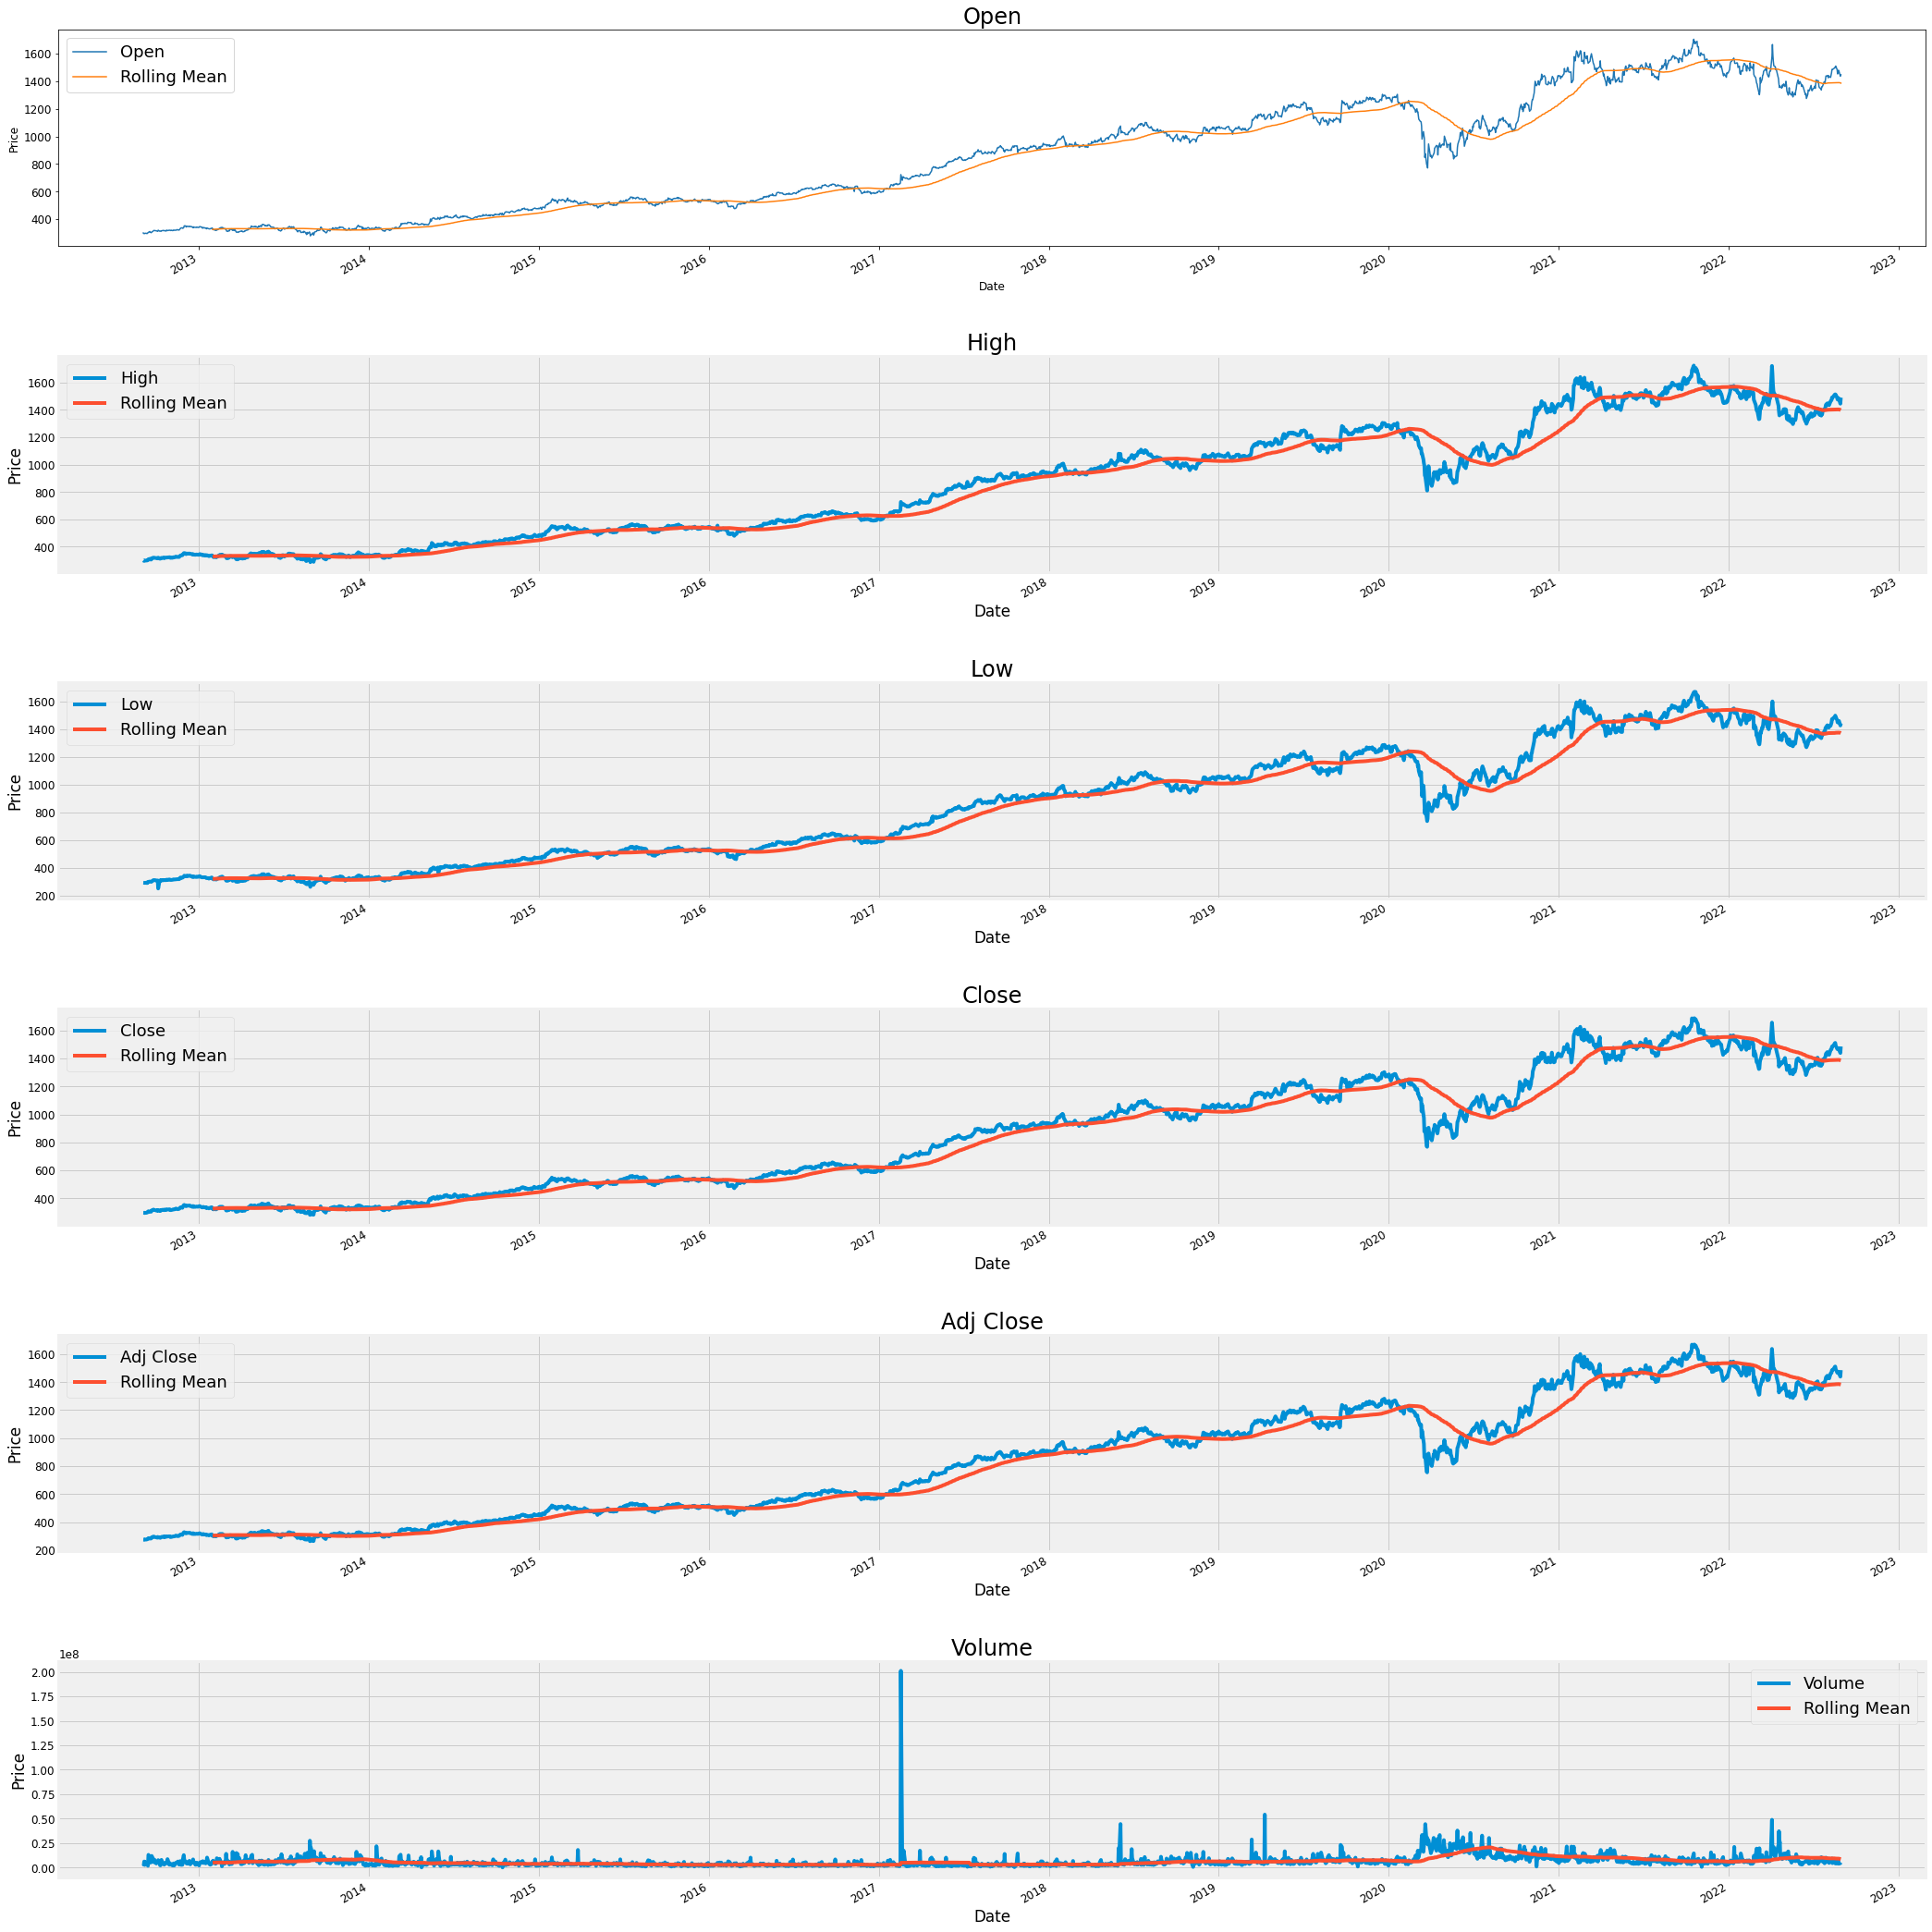

CPU times: total: 2.08 s
Wall time: 2.22 s


In [18]:
%%time
col_names = data.columns

fig = plt.figure(figsize=(30, 30))
for i in range(6):
  ax = fig.add_subplot(6,1,i+1)
  ax.plot(data.iloc[:,i],label=col_names[i])
  data.iloc[:,i].rolling(100).mean().plot(label='Rolling Mean')
  ax.set_title(col_names[i],fontsize=24)
  ax.set_xlabel('Date')
  ax.set_ylabel('Price')
  ax.patch.set_edgecolor('black')  
  plt.style.context('fivethirtyeight')
  plt.legend(prop={'size': 18})
  plt.style.use('fivethirtyeight')

fig.tight_layout(pad=3.0)
plt.show()

## Feature Selection

We can eliminate features like Open,Low, High Close automatically as they are high multicollinear with Adj Close .

We consider Adj Close as our target variables as it accounts for all corporate decisions like stock split and dividents.


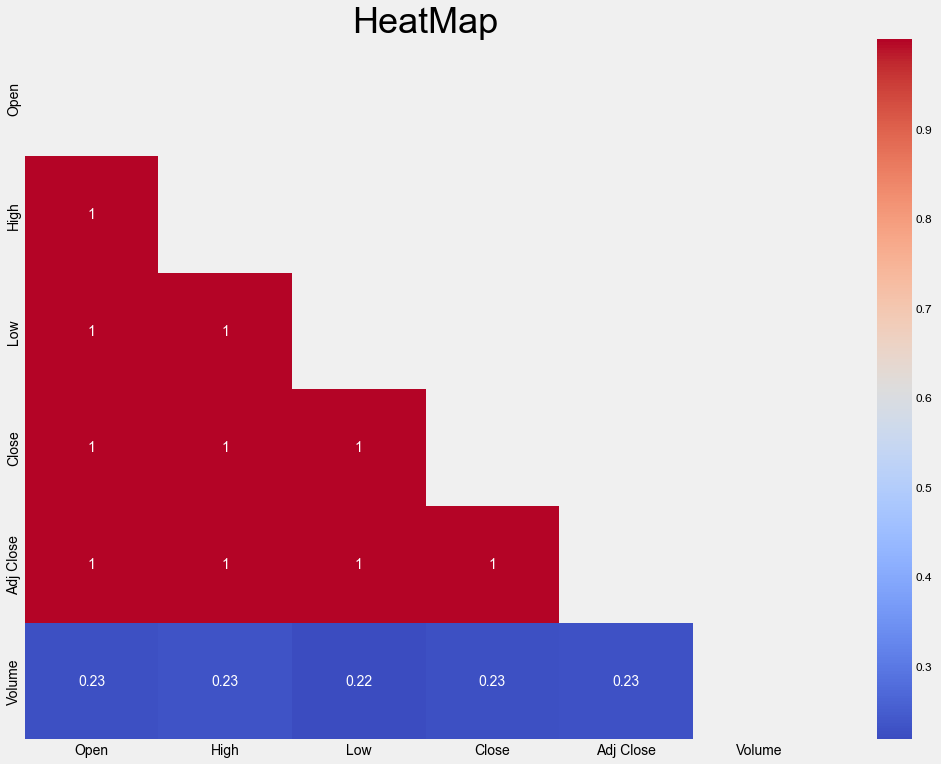

In [19]:
##HeatMap to Verify Multicollinearity between Features
fig = plt.figure(figsize=(16,12))
matrix = np.triu(data.corr())
ax = sns.heatmap(data.corr(),annot=True,annot_kws={"size":14},mask=matrix,cmap='coolwarm')
ax.tick_params(labelsize=14)
sns.set(font_scale=3)
ax.set_title('HeatMap')
plt.style.use('fivethirtyeight')
plt.show()

In [20]:
##Data after feature selection
data_feature_selected = data.drop(axis=1,labels=['Open','High','Low','Close','Volume'])

In [21]:
col_order = ['Date','Adj Close']
data_feature_selected = data_feature_selected.reindex(columns=col_order)
data_feature_selected

,Date,Adj Close
Date,,
2012-09-03,2012-09-03,275.351074
2012-09-04,2012-09-04,275.187897
2012-09-05,2012-09-05,276.120544
2012-09-06,2012-09-06,274.278534
2012-09-07,2012-09-07,275.327820
...,...,...
2022-08-24,2022-08-24,1472.849976
2022-08-25,2022-08-25,1464.849976
2022-08-26,2022-08-26,1465.099976


## Resampling

In [22]:
##Resample Data to Monthly instead of Daily by Aggregating Using Mean
monthly_mean = data_feature_selected['Adj Close'].resample('M').mean()

In [23]:
monthly_data = monthly_mean.to_frame()
monthly_data

,Adj Close
Date,
2012-09-30,283.640938
2012-10-31,293.623522
2012-11-30,305.355231
2012-12-31,319.505443
2013-01-31,310.828511
...,...
2022-04-30,1430.530344
2022-05-31,1331.793102
2022-06-30,1344.845453


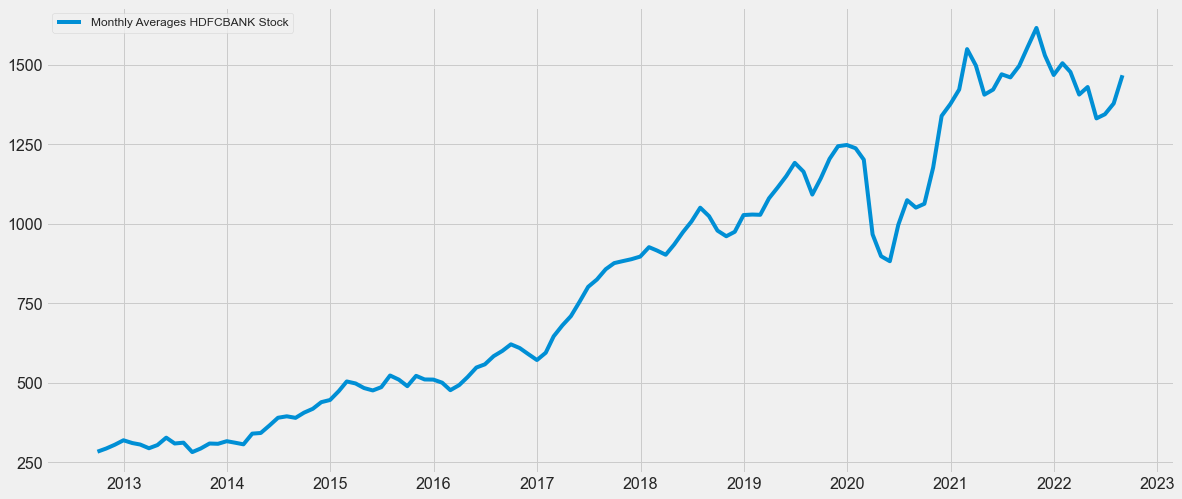

In [24]:
##Monthly Stock Price 
fig = plt.figure(figsize=(18,8))
plt.plot(monthly_data['Adj Close'],label='Monthly Averages HDFCBANK Stock')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.set_title('Monthly Resampled Data')
plt.style.use('fivethirtyeight')
plt.legend(prop={'size': 12})
plt.show()

## Exploratory Data Analysis

In [150]:
monthly_data['Year'] = monthly_data.index.year
monthly_data['Month'] = monthly_data.index.strftime('%B')
monthly_data['dayofweek'] = monthly_data.index.strftime('%A')
monthly_data['quarter'] = monthly_data.index.quarter
monthly_data

,Adj Close,Year,Month,dayofweek,quarter
Date,,,,,
2012-09-30,283.640938,2012,September,Sunday,3
2012-10-31,293.623522,2012,October,Wednesday,4
2012-11-30,305.355231,2012,November,Friday,4
2012-12-31,319.505443,2012,December,Monday,4
2013-01-31,310.828511,2013,January,Thursday,1
...,...,...,...,...,...
2022-04-30,1430.530344,2022,April,Saturday,2
2022-05-31,1331.793102,2022,May,Tuesday,2
2022-06-30,1344.845453,2022,June,Thursday,2


(array([0.    , 0.0002, 0.0004, 0.0006, 0.0008, 0.001 , 0.0012, 0.0014,
        0.0016]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

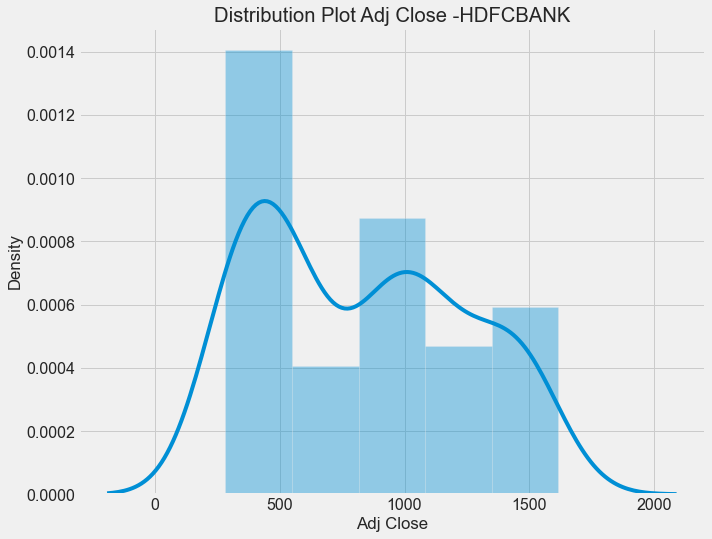

In [151]:
##Checking Distribution of Our Data 
fig = plt.figure(figsize=(10,8))
sns.distplot(monthly_data['Adj Close']).set_title("Distribution Plot Adj Close -HDFCBANK")
ax.tick_params(labelsize=12)
sns.set(font_scale=1)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

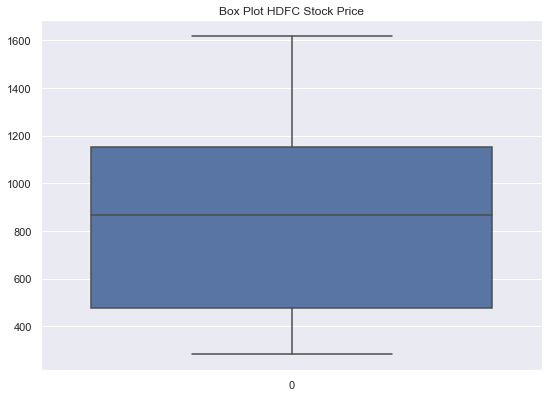

In [152]:
fig = plt.figure(figsize=(8,6))
sns.boxplot(monthly_data['Adj Close']).set_title('Box Plot HDFC Stock Price')
plt.style.context('fivethirtyeight')

Text(0.5, 1.0, 'QQ Plot HDFCBANK Stock Price')

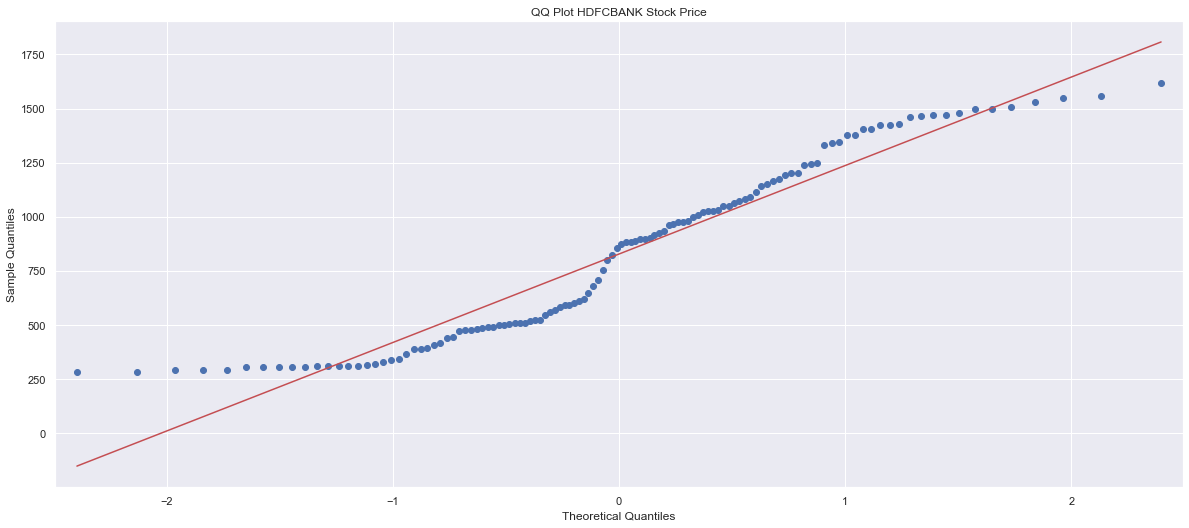

In [153]:
qq_plot = qq(monthly_data['Adj Close'],line='s')
plt.title('QQ Plot HDFCBANK Stock Price')

### QQ plot Inference :-

->Heavy Tailed Distribution-Curve at Extremities

-> Shows extent of both right and left skews

->Shows Distribution is Not following Gaussian Normal Distribution


In [154]:
print('Skewness of Distribution is ',monthly_data['Adj Close'].skew())
print('Kurtosis of Distribution is ',monthly_data['Adj Close'].kurtosis())

Skewness of Distribution is  0.2626501180800158
Kurtosis of Distribution is  -1.2695636949764681


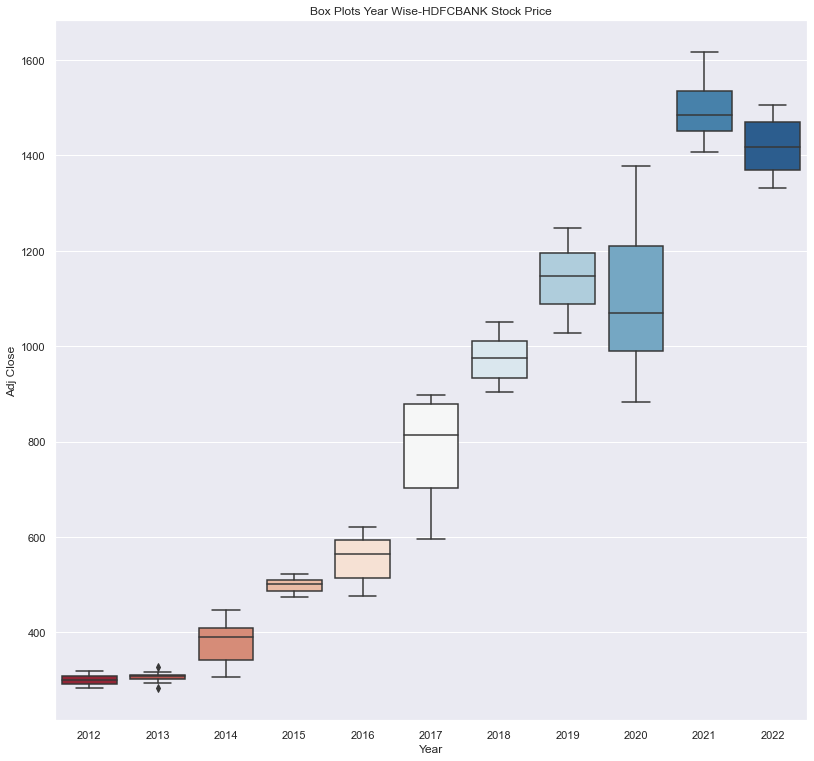

In [156]:
plt.figure(figsize=(12,12))
ax = sns.boxplot(x=monthly_data['Year'],y=monthly_data['Adj Close'],palette='RdBu')
ax.set_title('Box Plots Year Wise-HDFCBANK Stock Price')
plt.style.context('fivethirtyeight')

### Inferences Box Plot

->Outliers Present in Year 2012 and 2012

->Lot of Variability in Years 2014, 2017-21

->2020 most volatile year among all years

->Upward Rising Trend is shown


In [157]:
group_by_yr = []
list_years = monthly_data['Year'].unique()
dict_IQR = {}
for yr in list_years:
  group_by_yr.append('df' + str(yr)) 

for enum,yr in enumerate(list_years):
   group_by_yr[enum] = monthly_data[str(yr)]['Adj Close']
   dict_IQR[str(yr)] = stats.iqr(group_by_yr[enum])

In [158]:
##Interquartile Range(IQR) Year Wise for Stock Price
dict_IQR

{'2012': 17.764908286842058,
 '2013': 9.174419744136117,
 '2014': 67.46364715655903,
 '2015': 24.575605437666184,
 '2016': 79.29638153852818,
 '2017': 175.60425183371206,
 '2018': 78.55213512932892,
 '2019': 105.87131430102363,
 '2020': 220.9932366350979,
 '2021': 83.56823749642831,
 '2022': 99.75529396493516}

Text(0, 0.5, 'InterQuartile Range')

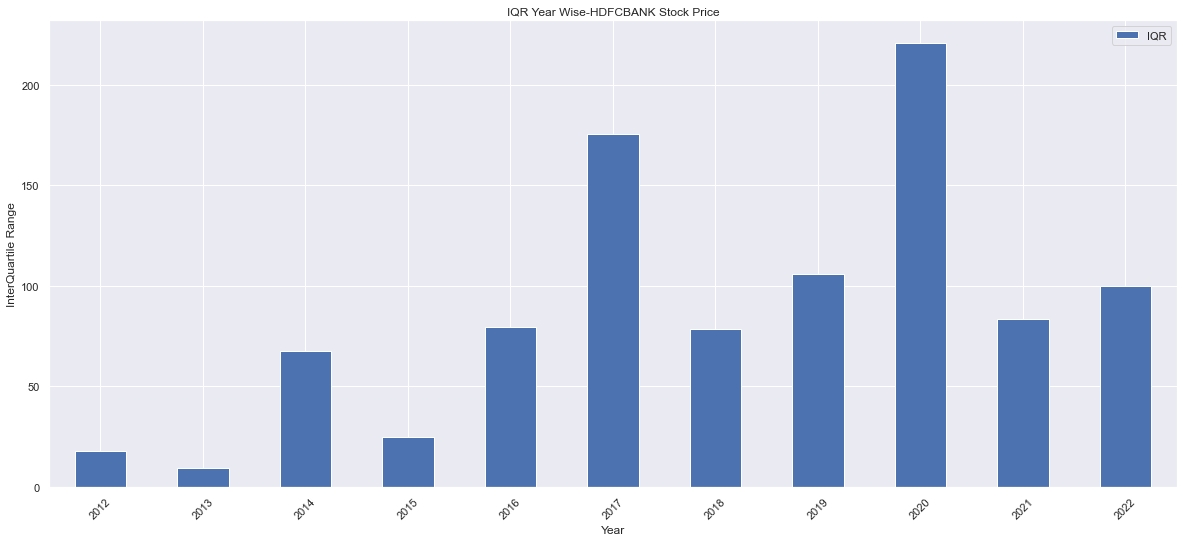

In [160]:
IQR_df = pd.DataFrame(dict_IQR.items(),columns=['Year','IQR'])
IQR_df.index = IQR_df['Year']
IQR_df.plot(kind='bar')
plt.xticks(rotation=45)
plt.style.context('fivethirtyeight')
plt.title('IQR Year Wise-HDFCBANK Stock Price')
plt.ylabel('InterQuartile Range')

->When Data is Not Normal Inter-Quartile Range(IQR) is Better Variability Metric than Standard Deviation as IQR is not affected by outliers.

->As observed with BoxPlot 2017 and 2020 are the most volatile Years for HDFCBANK Stock

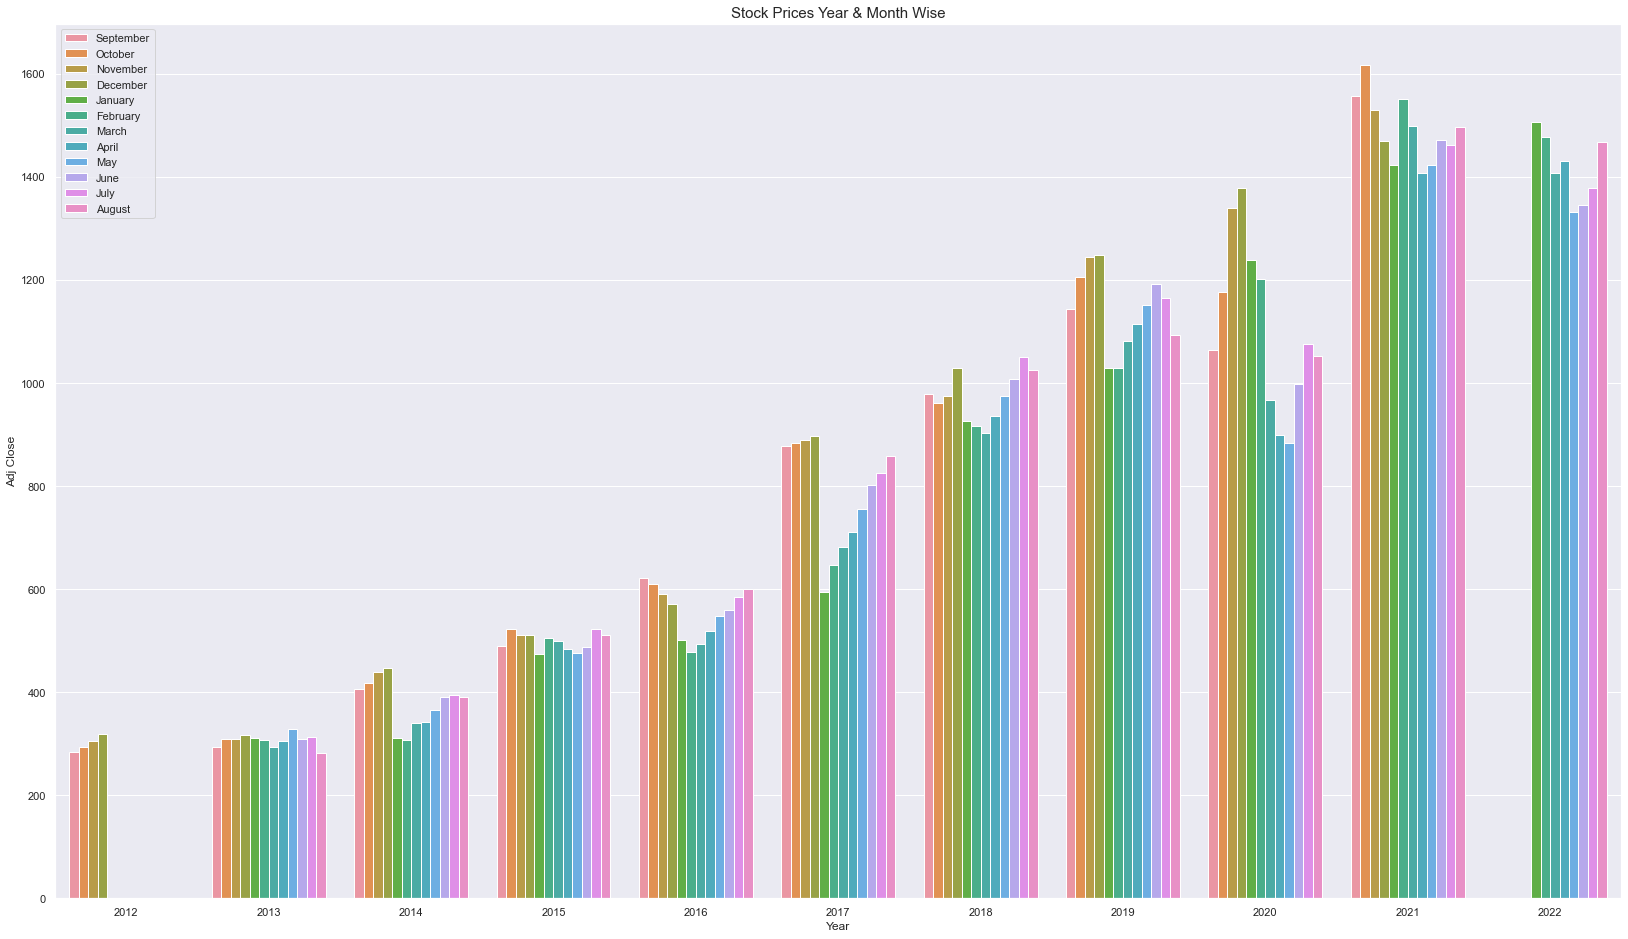

In [161]:
fig, ax = plt.subplots(figsize=(25,15))
palette = sns.color_palette("mako_r", 4)
a = sns.barplot(x="Year", y="Adj Close",hue = 'Month',data=monthly_data)
a.set_title("Stock Prices Year & Month Wise",fontsize=15)
plt.legend(loc='upper left')
plt.show()

Above figure shows that the Period from October-December seems to push stock price above in comparision to other months. The primary reason for this is as HDFCBANK has a product cycle release date during this time,the market is excited about upcoming earnings.

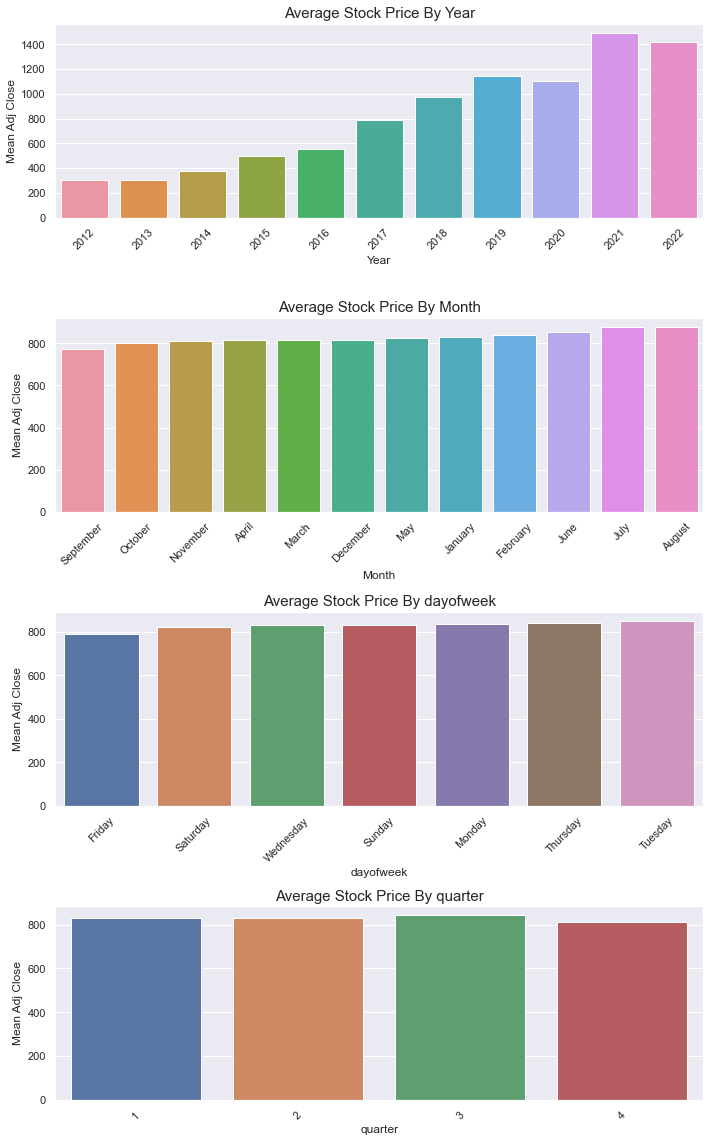

In [162]:
fig = plt.figure(figsize=(10,16))
fig.set_size_inches(10,16)
group_cols = monthly_data.columns

for enum,i in enumerate(group_cols[1:]):
  ax = fig.add_subplot(4,1,enum+1)
  Aggregated = pd.DataFrame(monthly_data.groupby(str(i))["Adj Close"].mean()).reset_index().sort_values('Adj Close')
  sns.barplot(data=Aggregated,x=str(i),y="Adj Close",ax=ax)
  ax.set(xlabel=str(i), ylabel='Mean Adj Close')
  ax.set_title("Average Stock Price By {}".format(str(i)),fontsize=15)
  plt.xticks(rotation=45)
  
plt.tight_layout(pad=1)

->According to Mean price by Years, 2020 and 2022 are the only years where Mean price is lower than previous Year.

->Average Stock Price is lower at start of the week in comparision to the end of the week.

->The Average Price is Highest in the Month of July.

->Q3 is the best for HDFCBANK according to average stock price. By earnings figures Q3 has always been strong for HDFCBANK.

# Decomposition of Time Series

<Figure size 1440x1152 with 0 Axes>

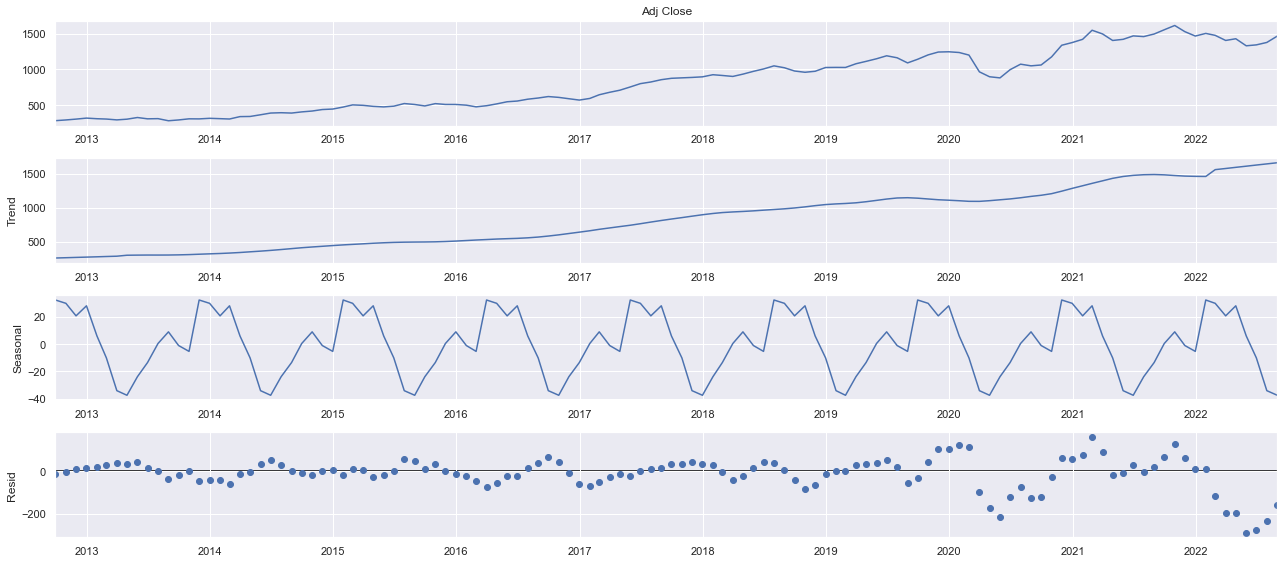

In [163]:
rcParams['figure.figsize'] = 18, 8
plt.figure(figsize=(20,16)) 
from statsmodels.tsa.seasonal import seasonal_decompose
decomposed_series = sd(monthly_data['Adj Close'],model='additive',extrapolate_trend='freq', period=14)
decomposed_series.plot()
plt.show()

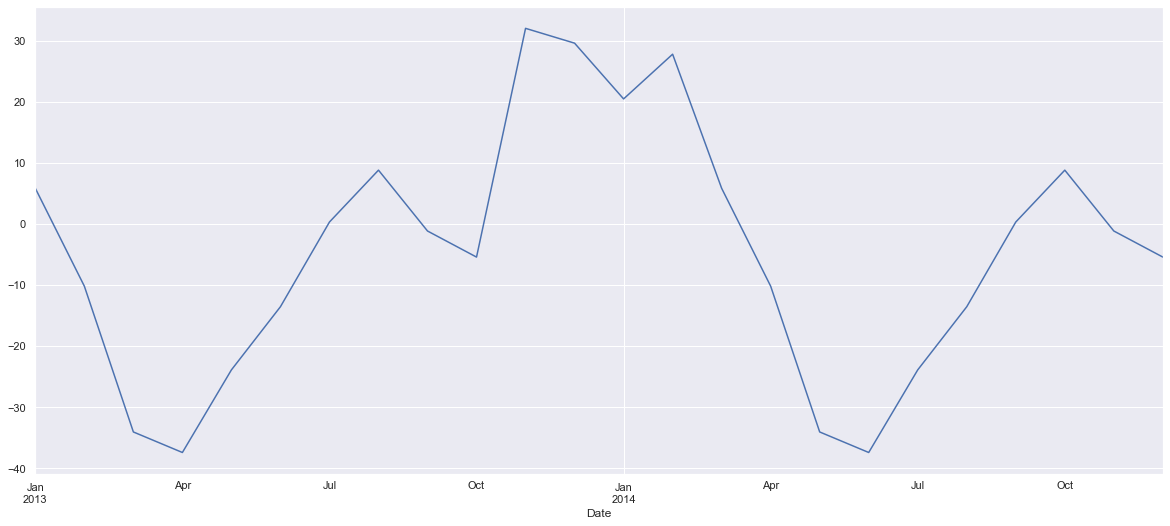

<Figure size 576x576 with 0 Axes>

In [164]:
##Drilling Down and Observing Seasonality
decomposed_series.seasonal['2013':'2014'].plot()
fig = plt.figure(figsize=(8,8))

### Inferences By Decomposition :-

->Trend : Overall an Upward Trend

->Seasonality :There appears to be seasonality,HDFCBANK has rallied during the moonsoon to winter season as we can see.

# Stationarity of Time Series

### Stationarity Test of Time Series

Using Augmented Dickey-Fuller(ADF) Test

### Null Hypothesis : Time series has a unit root -It is non-stationary

### Alternate Hypothesis : Time series does not have a unit root -It is stationary

Time Series is Stationary if we have constant mean,constant variance and No Trend and Seasonality.


In [165]:
##ADF Test-Statsmodels Library

def ad_fuller_func(X):
  result_ad_fuller = adfuller(X)
  print('ADF Statistic: %f' % result_ad_fuller[0])
  print('p-value: %f' %result_ad_fuller[1])
  print('Critical Values:')
  for key, value in result_ad_fuller[4].items():
	  print('\t%s: %.3f' % (key, value))
 
  if result_ad_fuller[0] < result_ad_fuller[4]['5%']:
    print('Reject Null Hypothesis(Ho)-Time Series is Stationary')
  else:
    print('Failed to Reject Ho-Time Series is Non-Stationary')

In [166]:
ad_fuller_func(monthly_data['Adj Close'])

ADF Statistic: -0.413167
p-value: 0.907877
Critical Values:
	1%: -3.488
	5%: -2.887
	10%: -2.580
Failed to Reject Ho-Time Series is Non-Stationary


Time Series is Not Stationary as observed earlier also by Decomposition(Trend and Seasonality Present)

Statistically verified by ADF Test

AutoCorrelation Function(ACF)

Text(0.5, 0, 'Lags')

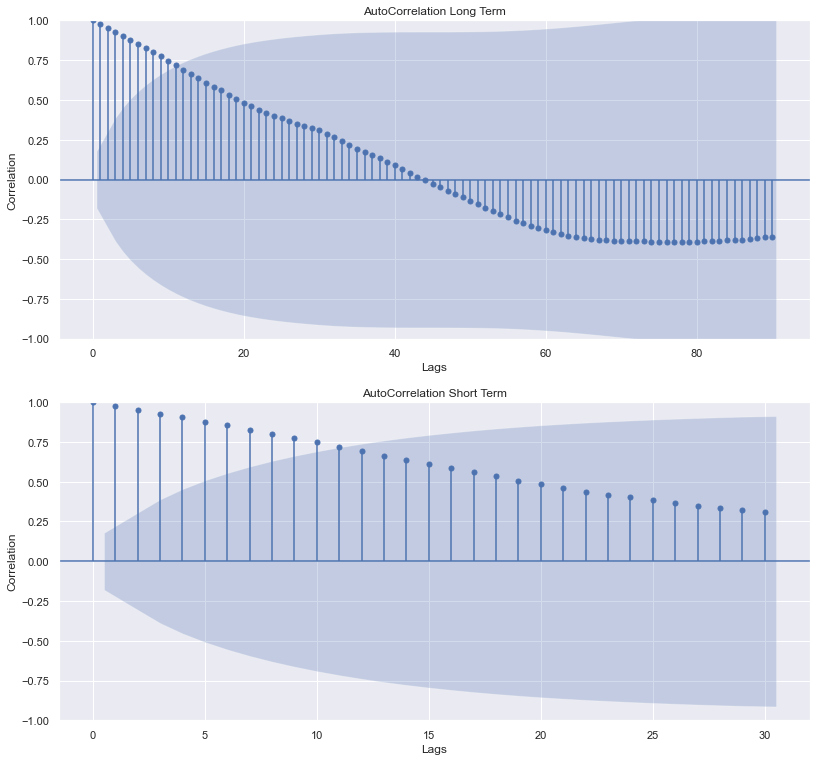

In [167]:
fig,(ax1,ax2) = plt.subplots(2,figsize=(12,12))
acf = plot_acf(monthly_data['Adj Close'],lags=90,ax=ax1)
ax1.set_title('AutoCorrelation Long Term')
acf = plot_acf(monthly_data['Adj Close'],lags=30,ax=ax2)
ax2.set_title('AutoCorrelation Short Term')
ax1.set_ylabel('Correlation')
ax1.set_xlabel('Lags')
ax2.set_ylabel('Correlation')
ax2.set_xlabel('Lags')

### Interpreting ACF Plot :-

->Slow Decay of correlation values indicates that the future values are heavily dependent on the lagged values . This shows that the series is not random and good for time series modelling .

->Also tells us series is Non-stationary

->It indicates a MA(1) process


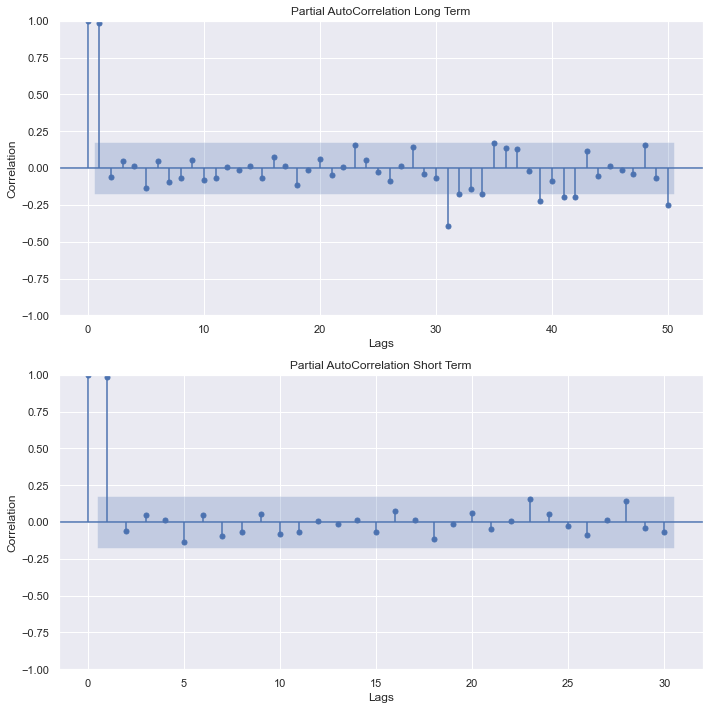

In [168]:
fig,(ax1,ax2) = plt.subplots(2,figsize=(10,10))
pacf = plot_pacf(monthly_data['Adj Close'],lags=50,ax=ax1)
ax1.set_title('Partial AutoCorrelation Long Term')
pacf = plot_pacf(monthly_data['Adj Close'],lags=30,ax=ax2)
ax2.set_title('Partial AutoCorrelation Short Term')
ax1.set_ylabel('Correlation')
ax1.set_xlabel('Lags')
ax2.set_ylabel('Correlation')
ax2.set_xlabel('Lags')
plt.tight_layout(pad=1)

Interpreting PACF Plot :-

->Sudden Decay at Lag-1

->Order of series seems AR(1)

### Transformations To Make Series Stationary

In [170]:
##Differencing By 1
monthly_diff = monthly_data['Adj Close'] - monthly_data['Adj Close'].shift(1)

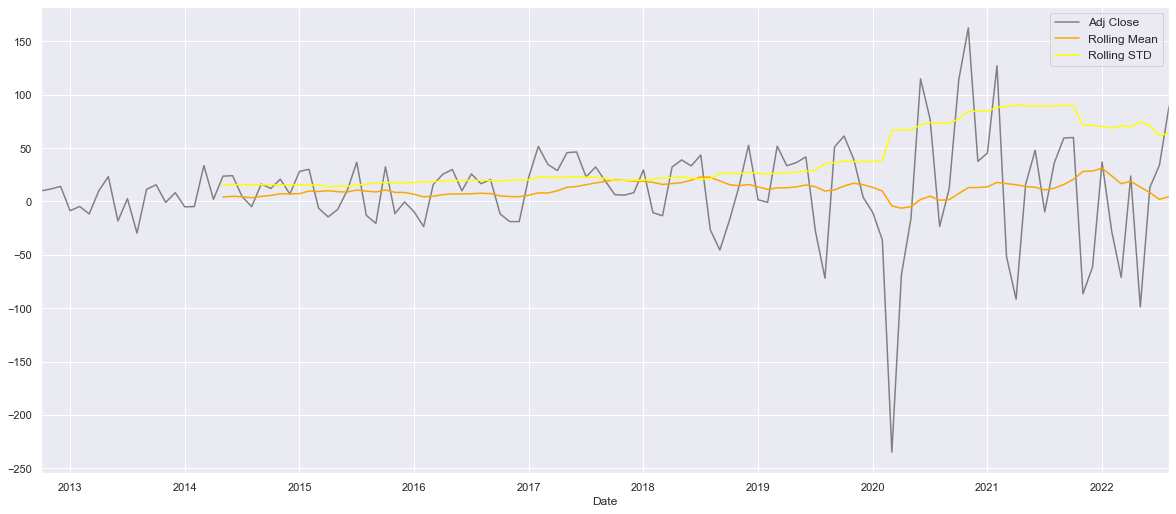

In [171]:
monthly_diff[1:].plot(c='grey')
monthly_diff[1:].rolling(20).mean().plot(label='Rolling Mean',c='orange')
monthly_diff[1:].rolling(20).std().plot(label='Rolling STD',c='yellow')
plt.legend(prop={'size': 12})

The series looks stationary as its having constant mean and variance .

In [172]:
##Checking if Time Series is Stationary by Running ADF Test
ad_fuller_func(monthly_diff[1:])

ADF Statistic: -7.547094
p-value: 0.000000
Critical Values:
	1%: -3.488
	5%: -2.887
	10%: -2.580
Reject Null Hypothesis(Ho)-Time Series is Stationary


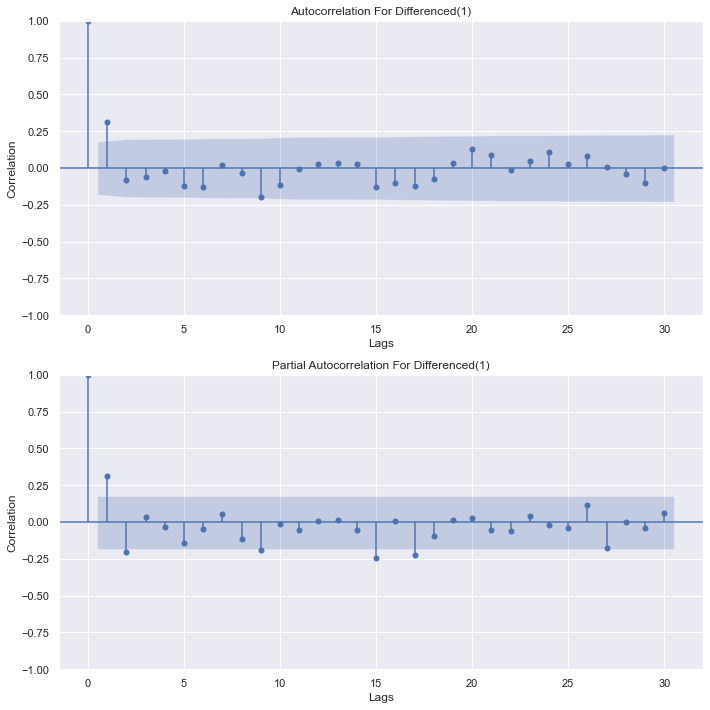

In [173]:
fig,(ax1,ax2) = plt.subplots(2,figsize=(10,10))
acf = plot_acf(monthly_diff[1:],lags=30,ax=ax1)
pacf = plot_pacf(monthly_diff[1:],lags=30,ax=ax2)
ax1.set_title('Autocorrelation For Differenced(1)')
ax1.set_ylabel('Correlation')
ax1.set_xlabel('Lags')
ax2.set_title('Partial Autocorrelation For Differenced(1)')
ax2.set_ylabel('Correlation')
ax2.set_xlabel('Lags')
plt.tight_layout(pad=1)

According to the ACF and PACF we can confirm that Differencing once has transformed series into Stationary

# Modelling Seasonal ARIMA

In [515]:
modelling_series = monthly_data['Adj Close']
modelling_series

Date
2012-09-30     283.640938
2012-10-31     293.623522
2012-11-30     305.355231
2012-12-31     319.505443
2013-01-31     310.828511
                 ...     
2022-04-30    1430.530344
2022-05-31    1331.793102
2022-06-30    1344.845453
2022-07-31    1378.797631
2022-08-31    1467.470007
Freq: M, Name: Adj Close, Length: 120, dtype: float64

### Train-Test Split

In [516]:
train,test = split(modelling_series,train_size=0.6,shuffle=False)
train.head(5000)

Date
2012-09-30     283.640938
2012-10-31     293.623522
2012-11-30     305.355231
2012-12-31     319.505443
2013-01-31     310.828511
                 ...     
2018-04-30     935.228536
2018-05-31     974.151969
2018-06-30    1007.463870
2018-07-31    1050.984661
2018-08-31    1024.375302
Freq: M, Name: Adj Close, Length: 72, dtype: float64

In [517]:
test.head(48)

Date
2018-09-30     978.878248
2018-10-31     961.163377
2018-11-30     975.182486
2018-12-31    1027.811780
2019-01-31    1029.399945
2019-02-28    1028.586988
2019-03-31    1080.437320
2019-04-30    1113.887670
2019-05-31    1150.284424
2019-06-30    1192.014610
2019-07-31    1164.150274
2019-08-31    1092.261731
2019-09-30    1143.365825
2019-10-31    1204.663940
2019-11-30    1244.415216
2019-12-31    1248.149135
2020-01-31    1237.855097
2020-02-29    1201.879279
2020-03-31     967.078706
2020-04-30     898.417728
2020-05-31     882.584453
2020-06-30     997.480427
2020-07-31    1074.600655
2020-08-31    1051.194327
2020-09-30    1063.210219
2020-10-31    1177.011515
2020-11-30    1339.562329
2020-12-31    1377.144681
2021-01-31    1422.551569
2021-02-28    1549.671954
2021-03-31    1497.950957
2021-04-30    1406.439472
2021-05-31    1422.430969
2021-06-30    1470.493053
2021-07-31    1460.739752
2021-08-31    1496.928513
2021-09-30    1556.337769
2021-10-31    1616.260211
2021-11

In [518]:
print('Train',len(train))
print('Test',len(test))

Train 72
Test 48


In [179]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of grid search Model parameter combinations for Seasonal-ARIMA')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))

Examples of grid search Model parameter combinations for Seasonal-ARIMA
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)


In [180]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of grid search Model parameter combinations for Seasonal-ARIMA')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))

Examples of grid search Model parameter combinations for Seasonal-ARIMA
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)


Carrying out Grid Search to Select Parameters especially for Seasonal Component of the Time Series .

Parameters for Series already indicate Non-Seasonality Part with Order (1,1,1).

AR(1) derived by the PACF plot

MA(1) derived by the ACF Plot

Differencing(1) derived by differencing and observing stationarity.

## Hyper Parameter Tuning for Model Order

In [50]:
list_param = []
list_param_seasonal=[]
list_results_aic=[]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = model.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            list_param.append(param)
            list_param_seasonal.append(param_seasonal)
            list_results_aic.append(results.aic)
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1109.9007740956465
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:933.3565028117999
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:694.5629269991383
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:766.1339700166355
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:602.2916810547833
ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:453.818352745538
ARIMA(0, 0, 0)x(0, 2, 0, 12)12 - AIC:586.6914978405555
ARIMA(0, 0, 0)x(0, 2, 1, 12)12 - AIC:998.7931140080885
ARIMA(0, 0, 0)x(0, 2, 2, 12)12 - AIC:295.71105534297646
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:687.0338264907878
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:649.0797556058711
ARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:514.5624118605825
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:600.5843588601888
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:568.5259601107424
ARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:410.37272301634295
ARIMA(0, 0, 0)x(1, 2, 0, 12)12 - AIC:447.2400992925642
ARIMA(0, 0, 0)x(1, 2, 1, 12)12 - AIC:1220.0225421255623
ARIMA(0, 0, 0)x(1, 2, 2, 12)12 - AIC:297.0976361432462
ARIMA(0

By Observing the Lowest AIC , we come to Seasonality Order of (2,2,0)12 and non-seasonal component is (1,1,1) as derived earlier by correlograms.

Seasonal Arima is used as we have seasonality component present. During Fall time period (July-Nov) the stock seems to rally on the news of product launch and product releases in that cycle of the year.


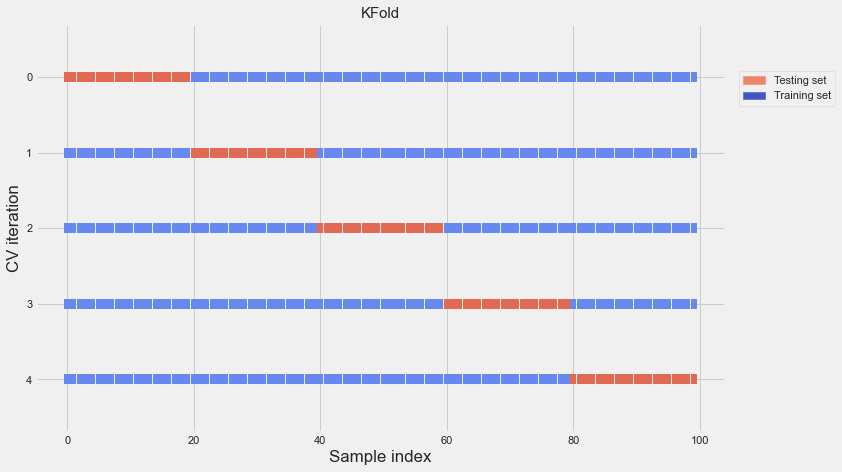

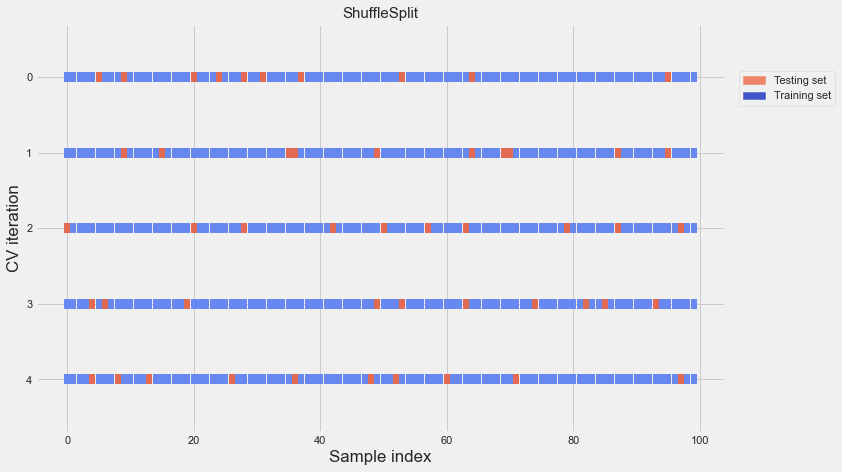

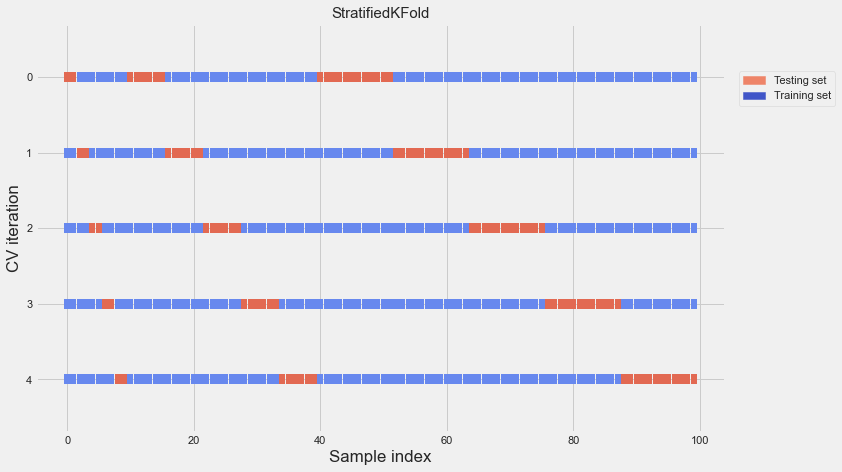

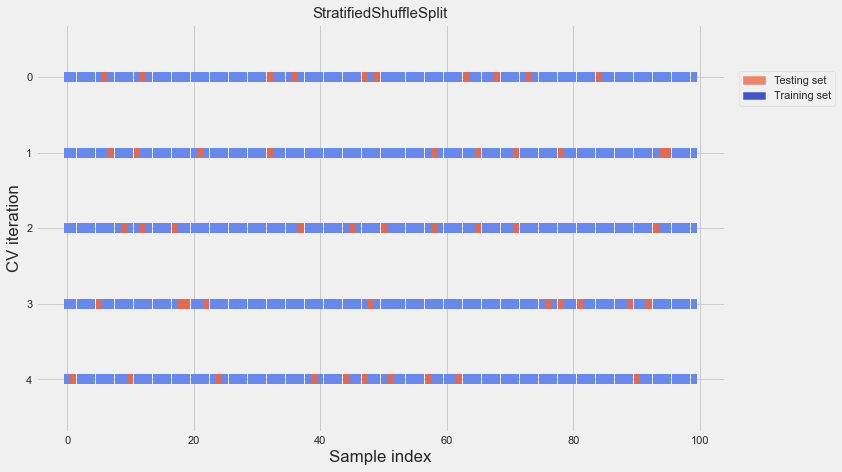

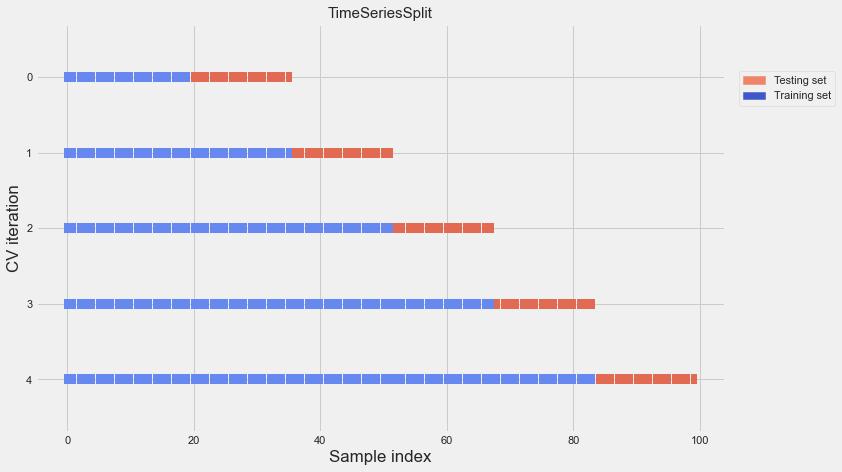

In [181]:
pd.options.display.max_columns = 30
plt.rcParams.update({'figure.max_open_warning': 0})
plt.style.use('fivethirtyeight')
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
warnings.filterwarnings('ignore')

cvs = [KFold, ShuffleSplit, StratifiedKFold, StratifiedShuffleSplit, TimeSeriesSplit]
n_points = 100
n_splits = 5
X = np.random.randn(100, 10)
percentiles_classes = [.1, .3, .6]
y = np.hstack([[ii] * int(100 * perc) for ii, perc in enumerate(percentiles_classes)])

# Function modified from https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

def plot_cv_indices(cv, n_splits, X, y, date_col = None):
    """Create a sample plot for indices of a cross-validation object."""
    
    fig, ax = plt.subplots(1, 1, figsize = (11, 7))
    
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=10, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)
    # Formatting
    yticklabels = list(range(n_splits+2))
    
    if date_col is not None:
        tick_locations  = ax.get_xticks()
        tick_dates = [" "] + date_col.iloc[list(tick_locations[1:-1])].astype(str).tolist() + [" "]

        tick_locations_str = [str(int(i)) for i in tick_locations]
        new_labels = ['\n\n'.join(x) for x in zip(list(tick_locations_str), tick_dates) ]
        ax.set_xticks(tick_locations)
        ax.set_xticklabels(new_labels)
    
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+0.2, -.2])
    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
              ['Testing set', 'Training set'], loc=(1.02, .8))
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)

for i, cv in enumerate(cvs):
    this_cv = cv(n_splits=n_splits)
    plot_cv_indices(this_cv, n_splits, X, y, date_col=None)

Observations: 48
Training Observations: 24
Testing Observations: 24
Observations: 72
Training Observations: 48
Testing Observations: 24
Observations: 96
Training Observations: 72
Testing Observations: 24
Observations: 120
Training Observations: 96
Testing Observations: 24


<Figure size 1296x576 with 0 Axes>

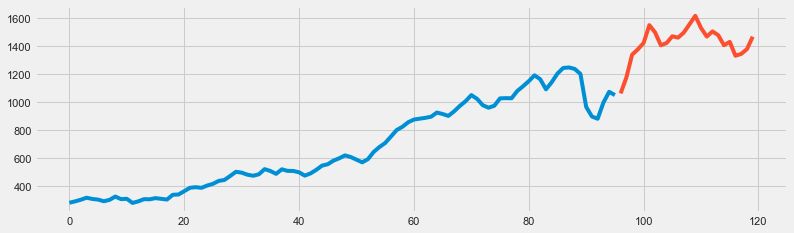

In [590]:
## Using TimeSeriesSplit from sklearn library
time_series_splits = TimeSeriesSplit(n_splits=4)
X = modelling_series.values
plt.figure(1)
fig = plt.figure(figsize=(12, 12))

index = 1
for train_index, test_index in time_series_splits.split(X):
    train = X[train_index]
    test =  X[test_index]
    print('Observations: %d' % (len(train) + len(test)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d' % (len(test)))
    
plt.subplot(310 + index)
plt.plot(train)
plt.plot([None for i in train] + [x for x in test])
plt.title(''.format())
index += 1
plt.show()

Train and Test different pairs across time series.

In [591]:
train_list = {}
test_list = {}
time_series_splits = TimeSeriesSplit(n_splits=5)
X = modelling_series.values

index = 1
for train_index, test_index in time_series_splits.split(X):
    train = X[train_index]
    test = X[test_index]
    train_list[index] = train
    test_list[index] = test
    index += 1

In [592]:
def backtest_model(train,test):
    model = sm.tsa.SARIMAX(train,order=(1,2,2),seasonal_order=(0,2,2,12))
    results=model.fit()


    # train_get_dates_beginning = '2012-09-30'
    # train_get_dates_ending = str(modelling_series.index[len(train)].date())
    # test_get_dates_beginning = train_get_dates_ending
    # test_get_dates_ending = str(modelling_series.index[len(train)+len(test)].date())


    # forecasts_train = results.predict(start=train_get_dates_beginning,end=train_get_dates_ending)
    # forecasts_test = results.predict(start=test_get_dates_beginning,end=test_get_dates_ending)

    forecasts_train = results.predict(start=0,end=len(train))
    forecasts_test = results.predict(start=len(train),end=len(train)+len(test))


    fig,(ax1,ax2) = plt.subplots(2,figsize=(18,10))

    train = pd.DataFrame(train)
    test = pd.DataFrame(test)

    forecasts_train = pd.DataFrame(forecasts_train)
    forecasts_test = pd.DataFrame(forecasts_test)

    forecasts_train.plot(label='Forecasts',ax=ax1,title='SARIMA Forecasting -Train Data')
    train.plot(label='Actual',ax=ax1)
    ax1.set_ylabel('Stock Price')
    ax1.set_xlabel('Time')


    forecasts_test.plot(label='Forecasts',ax=ax2,title='SARIMA Forecasting -Test Data')
    test.plot(label='Actual',ax=ax2)
    ax2.set_ylabel('Stock Price')
    ax2.set_xlabel('Time')

    ax1.legend()
    ax2.legend()
    plt.tight_layout(pad=2)

# Backtest Set 1

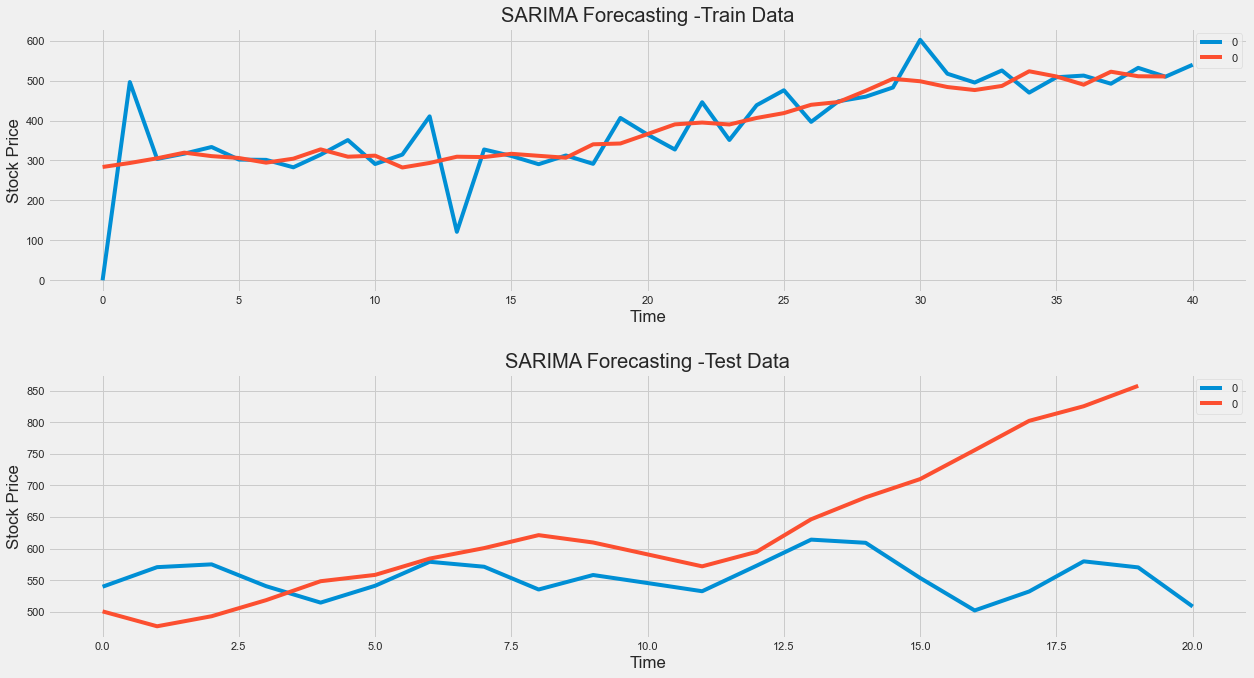

In [593]:
## Backtest Set-1
backtest_model(train_list[2],test_list[2])

# Backtest Set 2

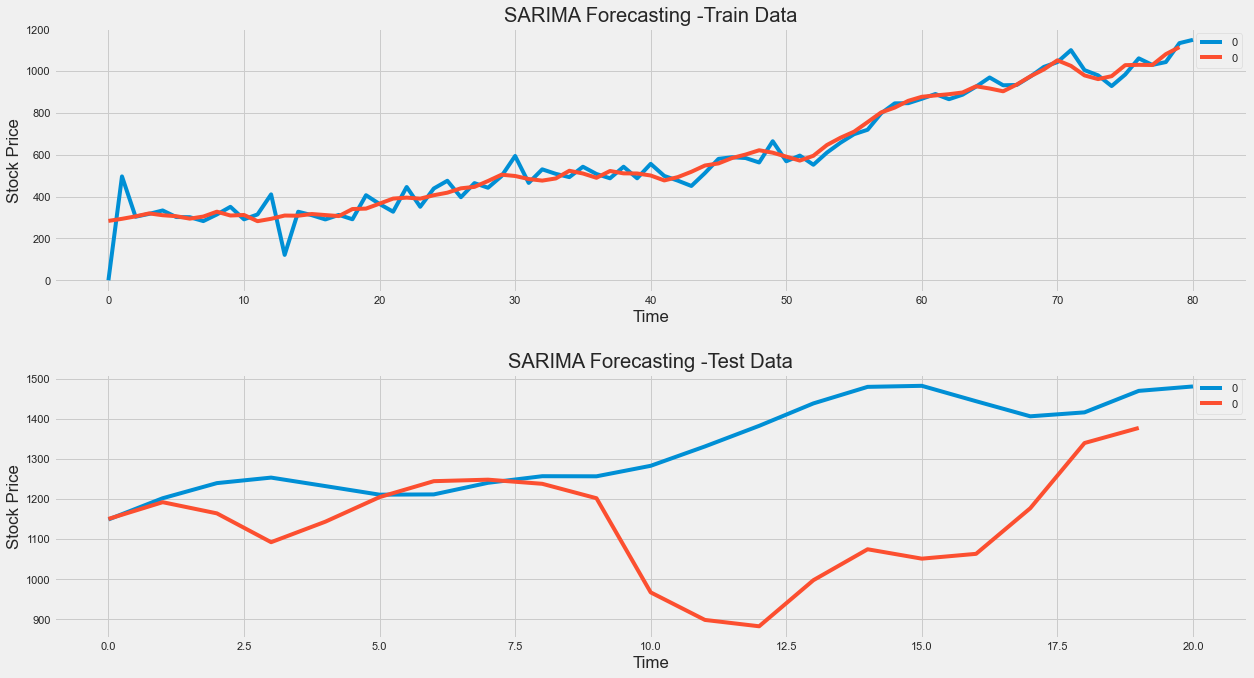

In [594]:
## Backtest Set-3
backtest_model(train_list[4],test_list[4])

# Backtest Set-3

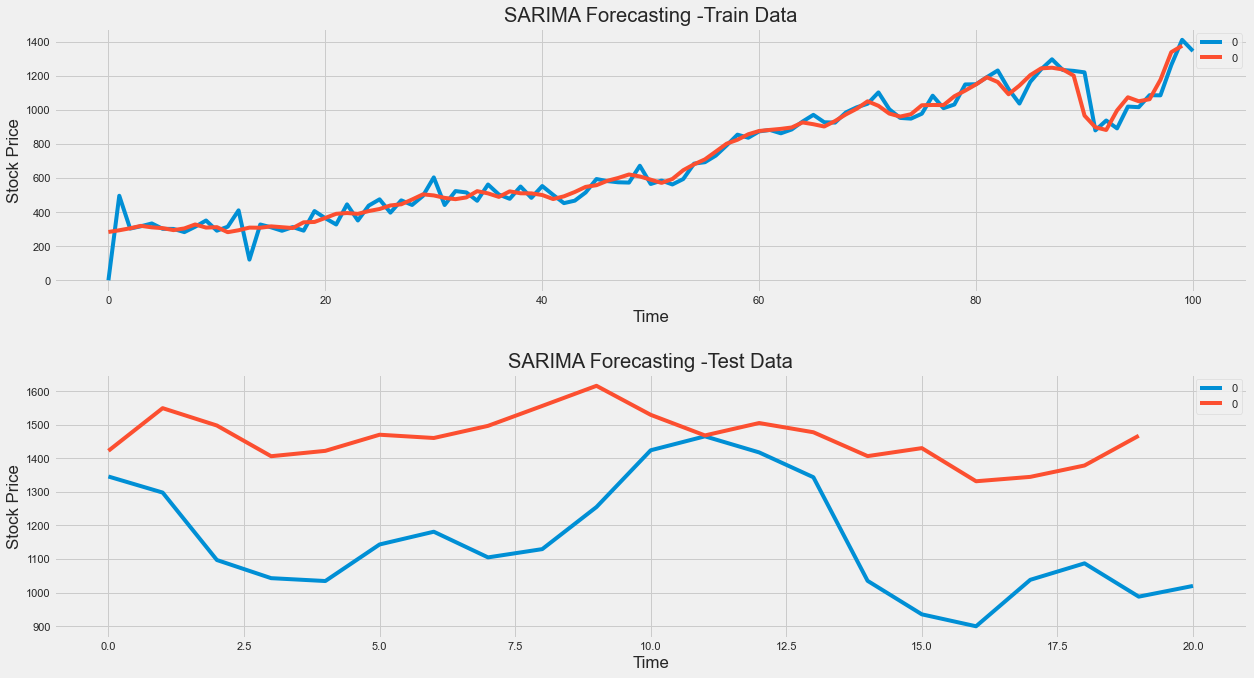

In [595]:
## Backtest Set-4
backtest_model(train_list[5],test_list[5])

By using backtesting we can validate our model on multiple train-test splits. Red is the training set and blue indicates test set.

## Forecasting Seasonal ARIMA

In [422]:
model=sm.tsa.statespace.SARIMAX(data['Adj Close'],order=(1, 2, 2),seasonal_order=(0,2,2,12))
results=model.fit()

In [521]:
model = sm.tsa.SARIMAX(train,order=(1,2,2),seasonal_order=(0,2,2,12))
results=model.fit()
forecasts_train = results.predict(start='2012-09-30',end='2018-08-31')
forecasts_test = results.predict(start='2018-09-30',end='2022-08-31')

In [437]:
type(modelling_series)
pd.core.indexes.base.Index

pandas.core.indexes.base.Index

In [470]:
model = sm.tsa.SARIMAX(train,order=(1,2,2),seasonal_order=(0,2,2,12))
results=model.fit()


In [471]:
results.predict

<bound method MLEResults.predict of <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x000001A68F8CCFA0>>

In [573]:
##Function to Calculate Result Metrics
def result_metrics(test_series,forecast_series,model_name):
  print('Result Metrics for {}'.format(model_name))
  print('R2 Score : ',round(r2_score(test_series,forecast_series),3))
  print('Mean Squared Error : ',round(mean_squared_error(test_series,forecast_series),3))
  print('Mean Absolute Error : ',round(mean_absolute_error(test_series,forecast_series),3))

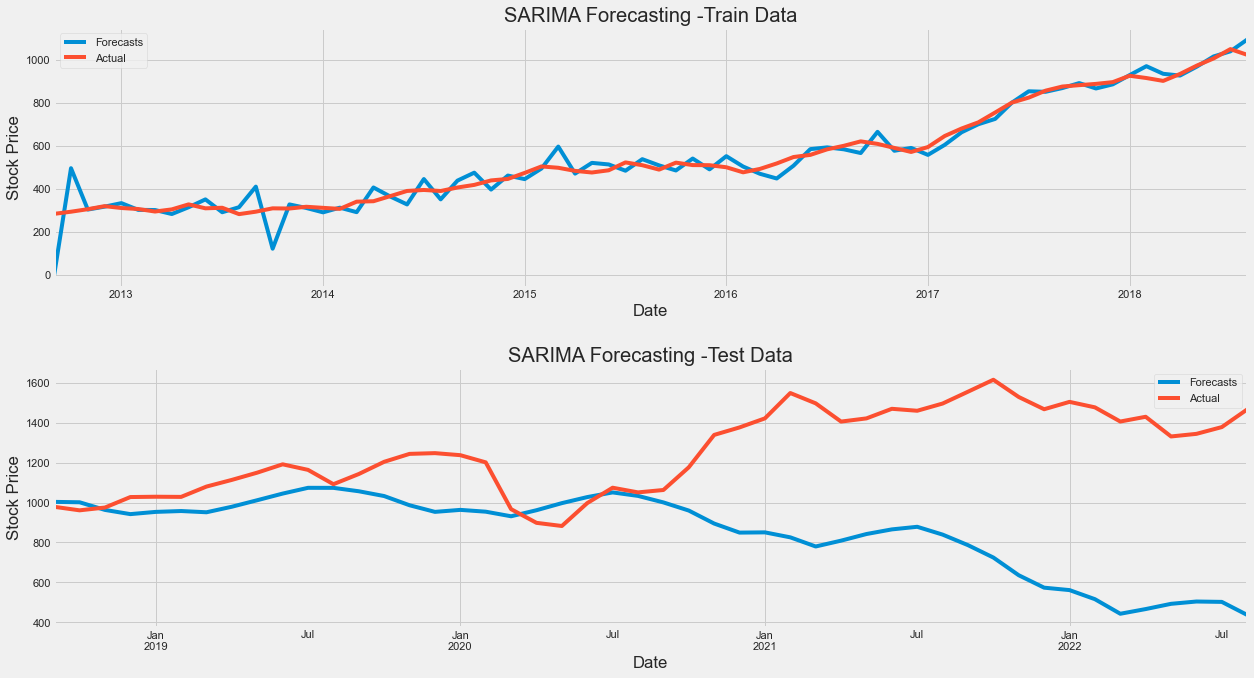

In [574]:
fig,(ax1,ax2) = plt.subplots(2,figsize=(18,10))

forecasts_train.plot(label='Forecasts',ax=ax1,title='SARIMA Forecasting -Train Data')
train.plot(label='Actual',ax=ax1)
ax1.set_ylabel('Stock Price')

forecasts_test.plot(label='Forecasts',ax=ax2,title='SARIMA Forecasting -Test Data')
test.plot(label='Actual',ax=ax2)
ax2.set_ylabel('Stock Price')

ax1.legend()
ax2.legend()
plt.tight_layout(pad=2)

In [575]:
print(result_metrics(train,forecasts_train,'SARIMA-Train Data'))
print('----')
print(result_metrics(test,forecasts_test,'SARIMA-Test Data'))

Result Metrics for SARIMA-Train Data
R2 Score :  0.931
Mean Squared Error :  3460.708
Mean Absolute Error :  36.635
None
----
Result Metrics for SARIMA-Test Data
R2 Score :  -5.968
Mean Squared Error :  293543.533
Mean Absolute Error :  411.44
None


In [576]:
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          Adj Close   No. Observations:                   72
Model:             SARIMAX(1, 2, 2)x(0, 2, 2, 12)   Log Likelihood                -227.747
Date:                            Tue, 13 Sep 2022   AIC                            467.494
Time:                                    18:35:21   BIC                            478.466
Sample:                                09-30-2012   HQIC                           471.604
                                     - 08-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6687      0.315     -2.120      0.034      -1.287      -0.051
ma.L1          0.1495     53.447   

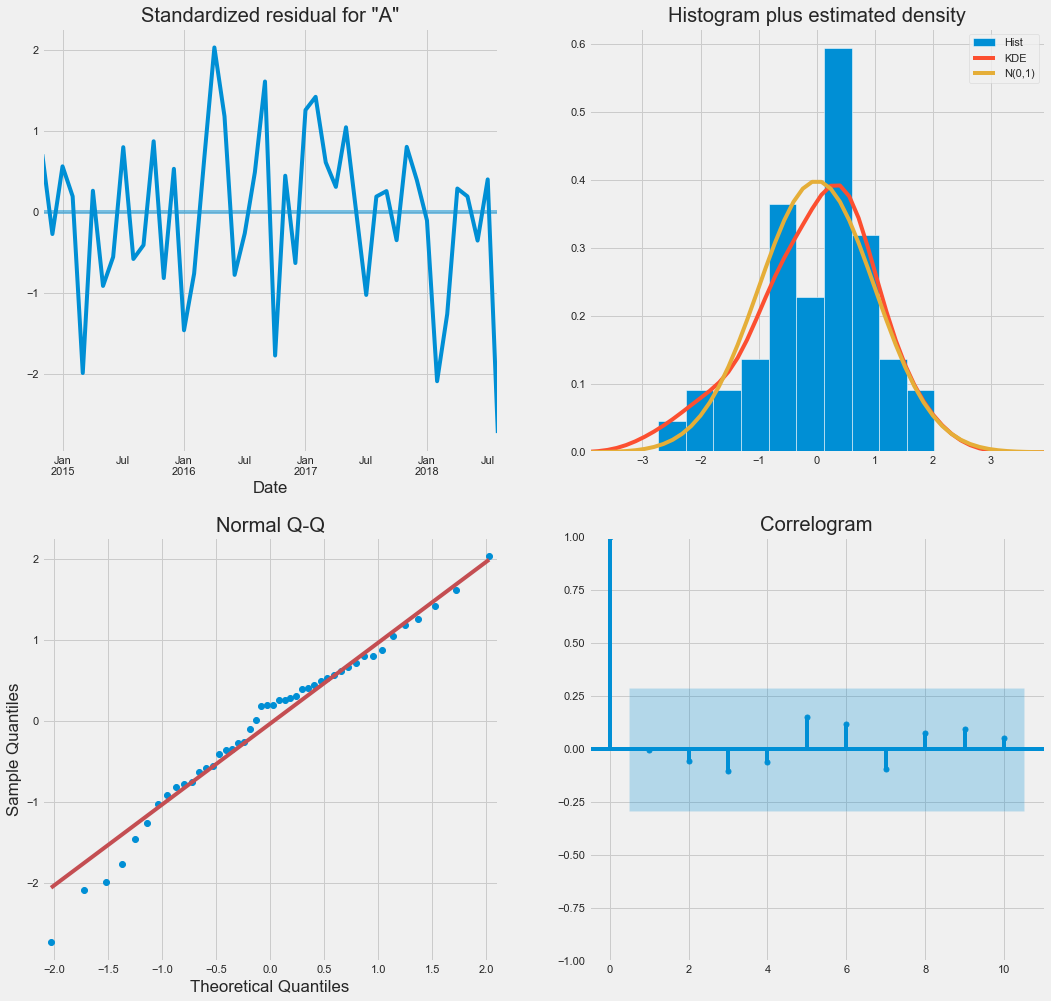

In [577]:
##Checking Model Diagnotics on Training Data
results.plot_diagnostics(figsize=(16, 16))
plt.show()

Inference from Residual Analysis :-

->We observe that the residual plot kind of follows stationarity.

->The Distribution of Training Data residuals is showing almost Normal Distribution.

->The QQPlot points towards Normal Distribution

->Correlogram shows no relation -which indicates they are un-correlated.

Overall the model is captured the Stock Price in a good manner.


## Residual Analysis Test Data

In [270]:
residuals_test = test-forecasts_test

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


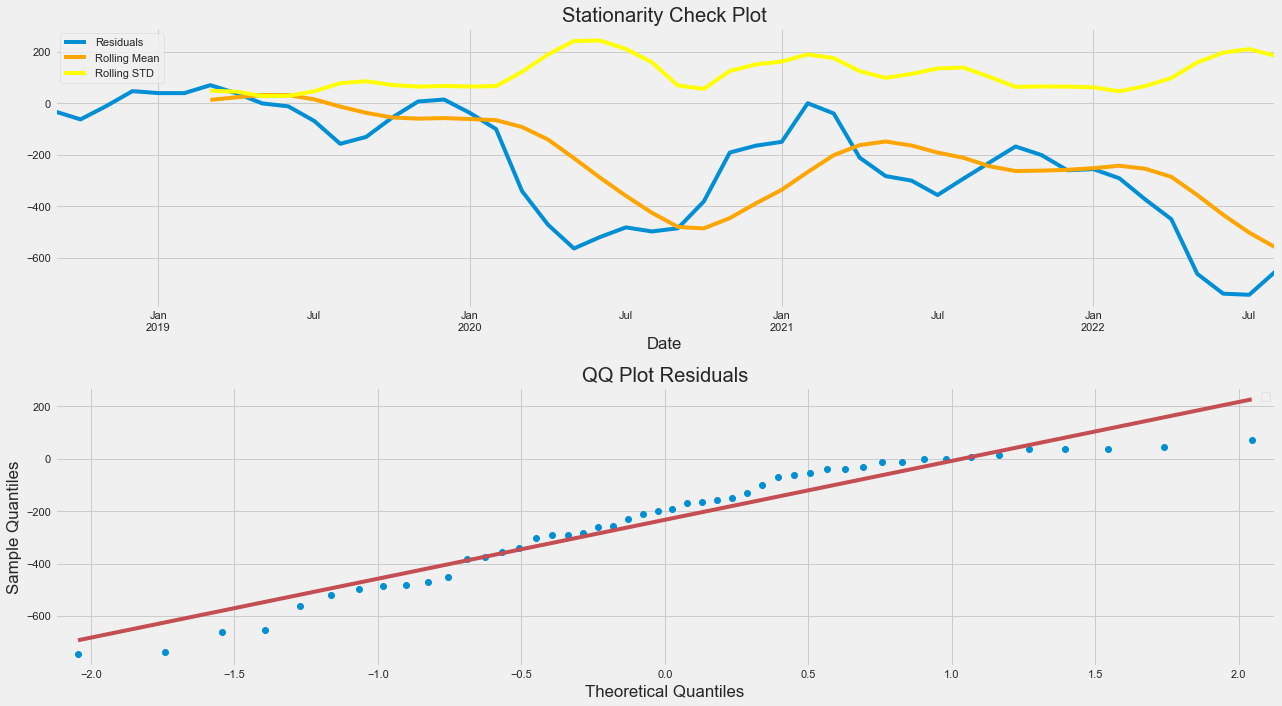

In [271]:
fig,(ax1,ax2) = plt.subplots(2,figsize=(18,10))


residuals_test.plot(label='Residuals',ax=ax1,title='Stationarity Check Plot')
residuals_test.rolling(7).mean().plot(label='Rolling Mean',c='orange',ax=ax1)
residuals_test.rolling(7).std().plot(label='Rolling STD',c='yellow',ax=ax1)

qq_plot = qq(residuals_test,line='s',ax=ax2)
ax2.set_title('QQ Plot Residuals')
ax1.legend()
ax2.legend()
plt.tight_layout(pad=1)

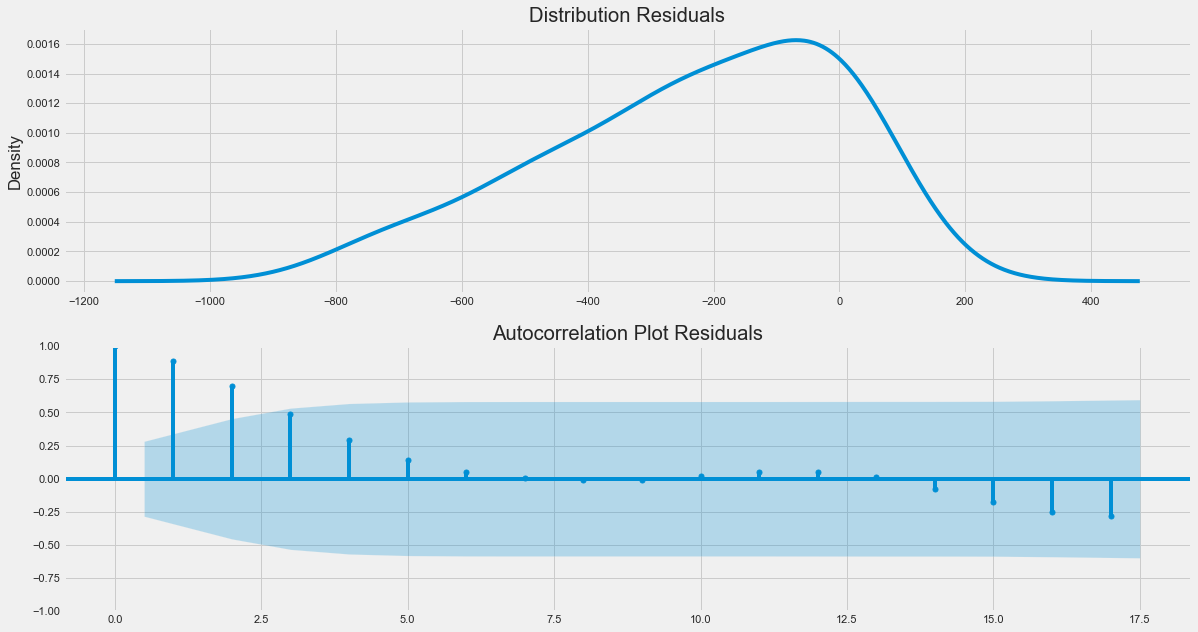

In [272]:
fig,(ax1,ax2) = plt.subplots(2,figsize=(18,10))

residuals_test.plot(kind='kde',ax=ax1,title='Distribution Residuals')

acf = plot_acf(residuals_test,ax=ax2,title='Autocorrelation Plot Residuals')

In [273]:
residuals_test.describe()

count     48.000000
mean    -233.040415
std      227.385388
min     -744.100264
25%     -376.023446
50%     -196.518426
75%      -36.432332
max       70.073697
dtype: float64

In [274]:
train_list = {}
test_list = {}
time_series_splits = TimeSeriesSplit(n_splits=4)
X = modelling_series.values

index = 1
for train_index, test_index in time_series_splits.split(X):
    train = X[train_index]
    test = X[test_index]
    train_list[index] = train
    test_list[index] = test
    index += 1

In [275]:
modelling_series

Date
2012-09-30     283.640938
2012-10-31     293.623522
2012-11-30     305.355231
2012-12-31     319.505443
2013-01-31     310.828511
                 ...     
2022-04-30    1430.530344
2022-05-31    1331.793102
2022-06-30    1344.845453
2022-07-31    1378.797631
2022-08-31    1467.470007
Freq: M, Name: Adj Close, Length: 120, dtype: float64

In [276]:
train_list[1]

array([283.64093821, 293.6235215 , 305.35523105, 319.5054427 ,
       310.82851113, 306.13545375, 294.46618495, 304.43913275,
       327.74347209, 309.3913863 , 311.99572878, 282.3464081 ,
       293.71201935, 309.33384195, 308.42807816, 316.6404171 ,
       311.58989817, 306.76367342, 340.40885005, 342.43854242,
       366.150706  , 390.32684324, 394.88540932, 390.04461821])

In [596]:
def backtest_model(train,test):    
    model = sm.tsa.SARIMAX(train,order=(1,2,2),seasonal_order=(0,2,2,12))
    results=model.fit()


    # train_get_dates_beginning = '2012-09-30'
    # train_get_dates_ending = str(modelling_series.index[len(train)].date())
    # test_get_dates_beginning = train_get_dates_ending
    # test_get_dates_ending = str(modelling_series.index[len(train)+len(test)].date())


    # forecasts_train = results.predict(start=train_get_dates_beginning,end=train_get_dates_ending)
    # forecasts_test = results.predict(start=test_get_dates_beginning,end=test_get_dates_ending)

    forecasts_train = results.predict(start=0,end=len(train))
    forecasts_test = results.predict(start=len(train),end=len(train)+len(test))


    fig,(ax1,ax2) = plt.subplots(2,figsize=(18,10))

    train = pd.DataFrame(train)
    test = pd.DataFrame(test)

    forecasts_train = pd.DataFrame(forecasts_train)
    forecasts_test = pd.DataFrame(forecasts_test)

    forecasts_train.plot(label='Forecasts',ax=ax1,title='SARIMA Forecasting -Train Data')
    train.plot(label='Actual',ax=ax1)
    ax1.set_ylabel('Stock Price')

    forecasts_test.plot(label='Forecasts',ax=ax2,title='SARIMA Forecasting -Test Data')
    test.plot(label='Actual',ax=ax2)
    ax2.set_ylabel('Stock Price')

    ax1.legend()
    ax2.legend()
    plt.tight_layout(pad=2)

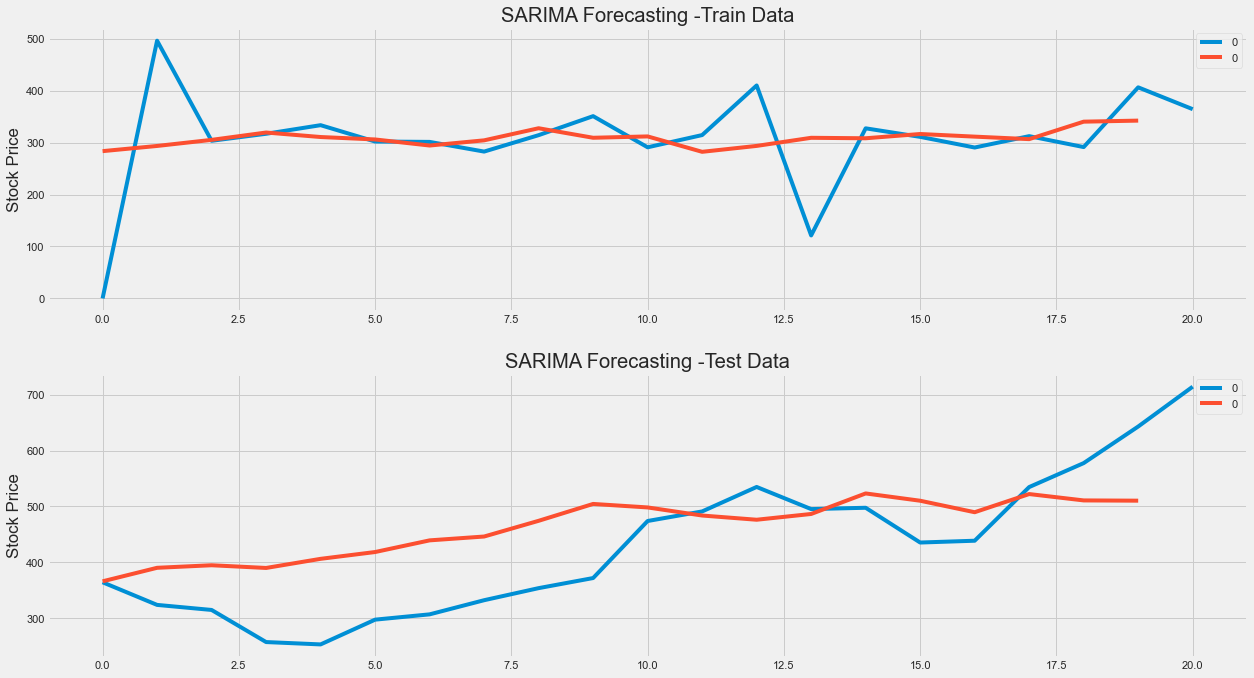

In [597]:
## Backtest Set-1
backtest_model(train_list[1],test_list[1])

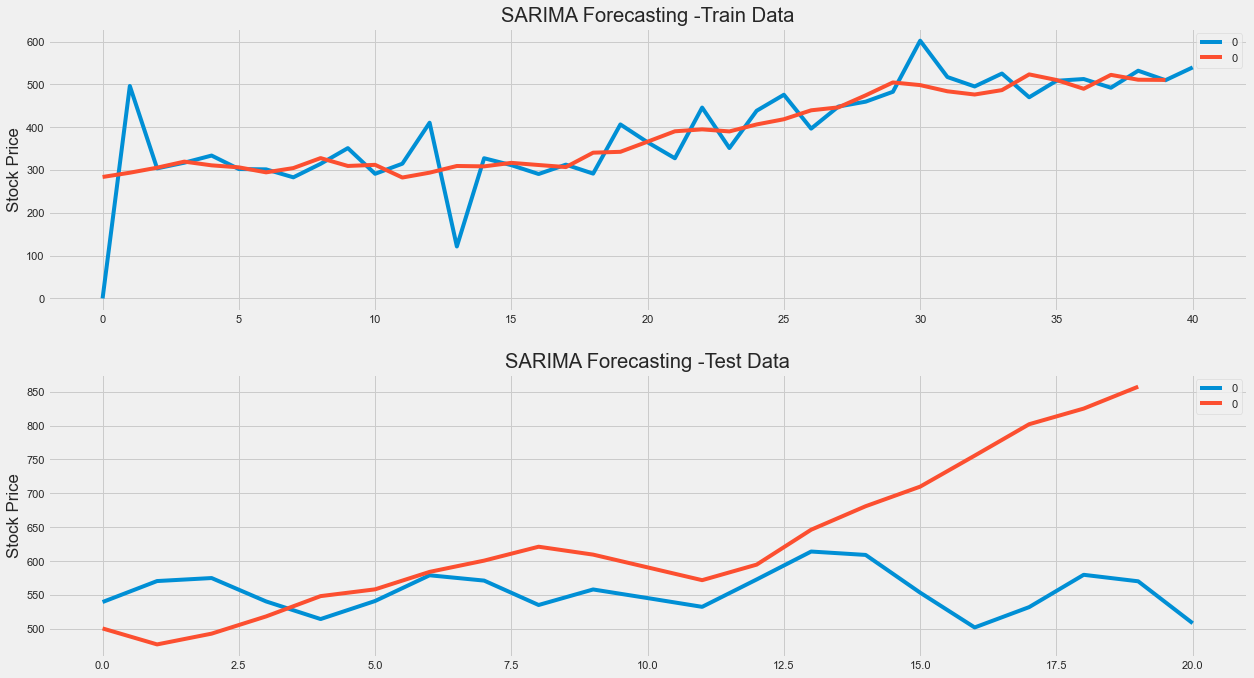

In [598]:
backtest_model(train_list[2],test_list[2])

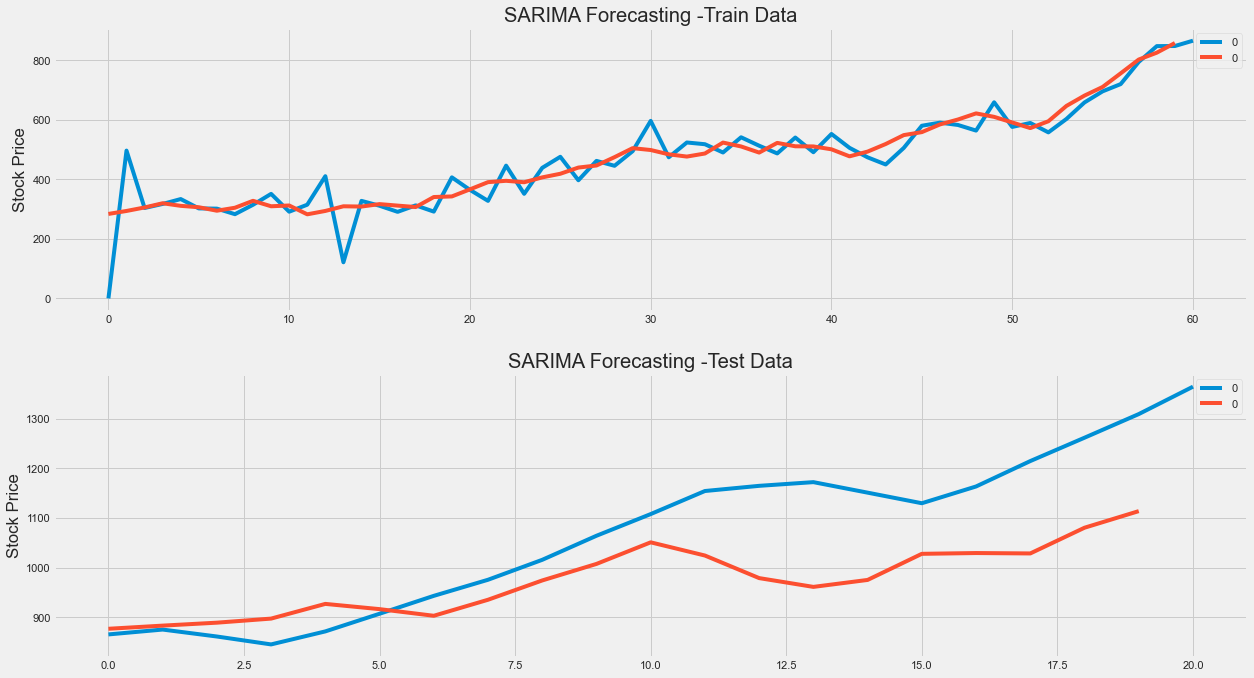

In [599]:
backtest_model(train_list[3],test_list[3])

In [610]:
forecasts_train

Date
2012-09-30       0.000000
2012-10-31     496.350497
2012-11-30     303.644982
2012-12-31     317.189067
2013-01-31     333.587942
                 ...     
2018-04-30     927.772090
2018-05-31     969.265158
2018-06-30    1016.791078
2018-07-31    1040.626742
2018-08-31    1095.500723
Freq: M, Name: predicted_mean, Length: 72, dtype: float64

In [ ]:
fig,(ax1,ax2) = plt.subplots(2,figsize=(18,10))

forecasts_train.plot(label='Forecasts',ax=ax1,title='SARIMA Forecasting -Train Data')
train.plot(label='Actual',ax=ax1)
ax1.set_ylabel('Stock Price')

forecasts_test.plot(label='Forecasts',ax=ax2,title='SARIMA Forecasting -Test Data')
test.plot(label='Actual',ax=ax2)
ax2.set_ylabel('Stock Price')

ax1.legend()
ax2.legend()
plt.tight_layout(pad=2)

### Seasonal ARIMA-Verdict

The mean value is close to zero but it suggests that there is some bias in the model. Overall the model has performed good for a problem like Stock Price Prediction being a difficult problem .

# Facebook's Prophet Model for Time Series

In [601]:
prophet_data = monthly_data
prophet_data['Date'] = prophet_data.index
prophet_data

,Adj Close,Date
Date,,
2012-09-30,283.640938,2012-09-30
2012-10-31,293.623522,2012-10-31
2012-11-30,305.355231,2012-11-30
2012-12-31,319.505443,2012-12-31
2013-01-31,310.828511,2013-01-31
...,...,...
2022-04-30,1430.530344,2022-04-30
2022-05-31,1331.793102,2022-05-31
2022-06-30,1344.845453,2022-06-30


In [602]:
prophet_data = prophet_data.reindex(columns=['Date','Adj Close'])

In [603]:
##Prophet needs two columns in form of ds and y being Date and series
prophet_data.rename(columns={'Date':'ds',
                   'Adj Close':'y'},inplace=True)

In [604]:
prophet_data

,ds,y
Date,,
2012-09-30,2012-09-30,283.640938
2012-10-31,2012-10-31,293.623522
2012-11-30,2012-11-30,305.355231
2012-12-31,2012-12-31,319.505443
2013-01-31,2013-01-31,310.828511
...,...,...
2022-04-30,2022-04-30,1430.530344
2022-05-31,2022-05-31,1331.793102
2022-06-30,2022-06-30,1344.845453


In [605]:
##Spliting Train Test 
prophet_train,prophet_test = split(prophet_data,train_size=0.6,shuffle=False)
print('Training Data Size :',len(prophet_train))
print('Testing Data Size :',len(prophet_test))

Training Data Size : 72
Testing Data Size : 48


In [606]:
##Model Fitting Basic Model
prophet_model = Prophet(yearly_seasonality=True)
prophet_model.fit(prophet_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [607]:
future= prophet_model.make_future_dataframe(periods=48,freq='M')

In [608]:
future

,ds
0,2012-09-30
1,2012-10-31
2,2012-11-30
3,2012-12-31
4,2013-01-31
...,...
115,2022-04-30
116,2022-05-31
117,2022-06-30
118,2022-07-31


Forecasting Prophet-Basic Model

In [540]:
##Predicting Using Prophet
forecast=prophet_model.predict(future)
forecast.index = prophet_data['y'].index

In [541]:
prophet_df = pd.concat([forecast['yhat'],prophet_data['y']],axis=1,ignore_index=True)
prophet_df.columns = ['Predicted','Actual']
prophet_df

,Predicted,Actual
Date,,
2012-09-30,293.791782,283.640938
2012-10-31,290.731305,293.623522
2012-11-30,286.217166,305.355231
2012-12-31,283.658111,319.505443
2013-01-31,293.485371,310.828511
...,...,...
2022-04-30,1913.476291,1430.530344
2022-05-31,1945.431083,1331.793102
2022-06-30,1975.855358,1344.845453


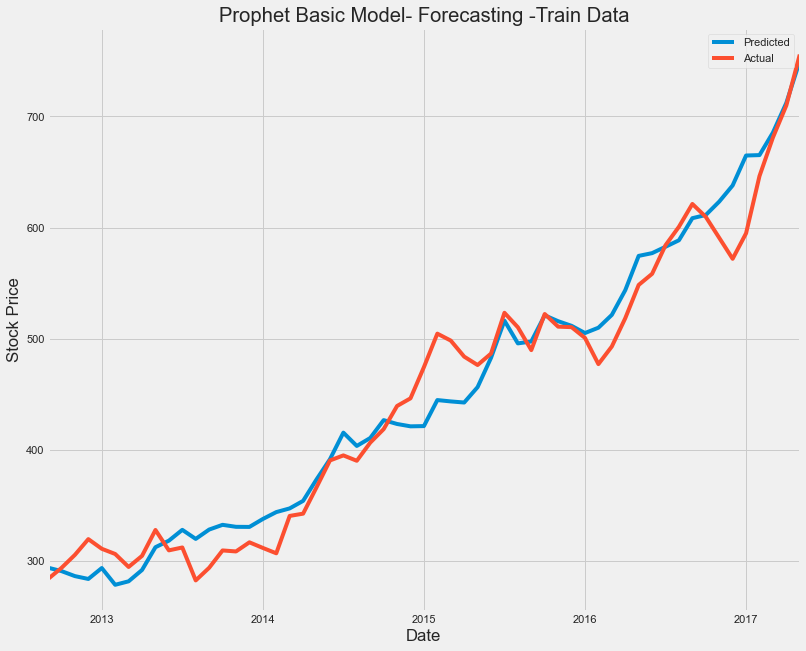

In [542]:
fig = plt.figure(figsize=(12,10))
prophet_df['Predicted'][:57].plot(label='Predicted')
prophet_df['Actual'][:57].plot(label='Actual')
plt.title('Prophet Basic Model- Forecasting -Train Data')
plt.ylabel('Stock Price')
plt.legend()

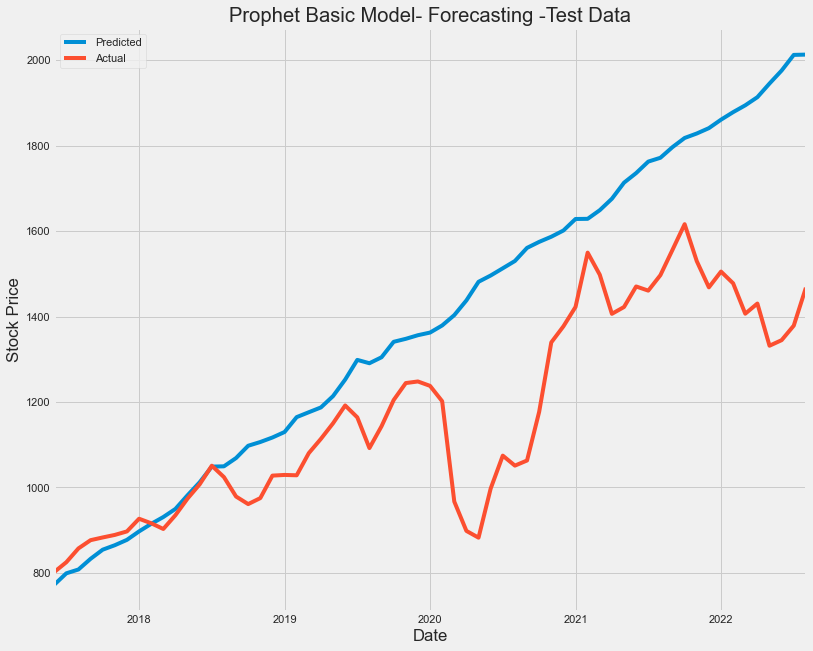

In [543]:
fig = plt.figure(figsize=(12,10))
prophet_df['Predicted'][57:].plot(label='Predicted')
prophet_df['Actual'][57:].plot(label='Actual')
plt.title('Prophet Basic Model- Forecasting -Test Data')
plt.ylabel('Stock Price')
plt.legend()

In [544]:
print(result_metrics(prophet_df['Actual'][:57],prophet_df['Predicted'][:57],'Prophet Basic-Train Data'))

Result Metrics for Prophet Basic-Train Data
R2 Score :  0.957
Mean Squared Error :  664.366
Mean Absolute Error :  19.649
None


In [545]:
print(result_metrics(prophet_df['Actual'][57:],prophet_df['Predicted'][57:],'Prophet Basic-Test Data'))

Result Metrics for Prophet Basic-Test Data
R2 Score :  -0.581
Mean Squared Error :  84706.488
Mean Absolute Error :  220.898
None


The Basic Prophet Model with default parameters overfits into the model as represented by the Train Test Accuracy differences.

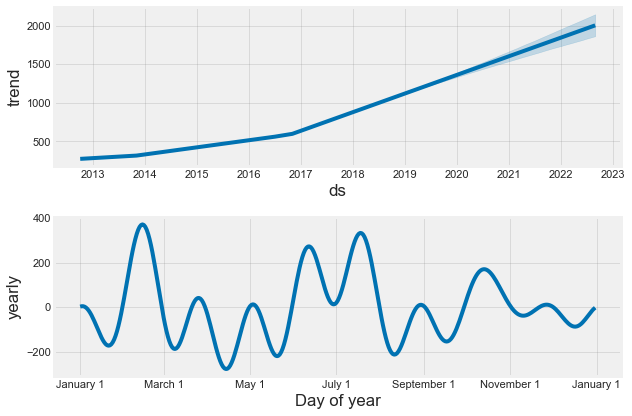

In [322]:
fig = prophet_model.plot_components(forecast)

In [546]:
print('Head',prophet_test.head(1))
print('Tail',prophet_test.tail(1))

Head                    ds           y
Date                             
2018-09-30 2018-09-30  978.878248
Tail                    ds            y
Date                              
2022-08-31 2022-08-31  1467.470007


Seasonal-ARIMA seems to have captured the model in a better way.

### Hyper-Tuning for Prophet Model

In [547]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.3,0.4],
              'holidays_prior_scale':[0.3,0.4],
              'n_changepoints' : [20,50]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 16


In [548]:
df = prophet_data 

In [549]:
prophet_train_hyper,prophet_test_hyper = split(prophet_data,train_size=0.7,shuffle=False)

In [550]:
prophet_test_hyper.head(5)

,ds,y
Date,,
2019-09-30,2019-09-30,1143.365825
2019-10-31,2019-10-31,1204.663940
2019-11-30,2019-11-30,1244.415216
2019-12-31,2019-12-31,1248.149135
2020-01-31,2020-01-31,1237.855097


In [552]:
x = prophet_test_hyper['ds']
y = prophet_test_hyper['y']

In [551]:
x = prophet_test_hyper['ds']
y = prophet_test_hyper['y']
x.shape
y.values.reshape(-1,1)

array([[1143.36582547],
       [1204.66394045],
       [1244.4152161 ],
       [1248.14913505],
       [1237.8550973 ],
       [1201.87927895],
       [ 967.07870633],
       [ 898.417728  ],
       [ 882.58445337],
       [ 997.48042709],
       [1074.60065487],
       [1051.19432729],
       [1063.21021891],
       [1177.01151533],
       [1339.5623291 ],
       [1377.14468105],
       [1422.55156865],
       [1549.67195425],
       [1497.95095676],
       [1406.43947237],
       [1422.43096925],
       [1470.49305318],
       [1460.7397519 ],
       [1496.92851324],
       [1556.33776852],
       [1616.2602111 ],
       [1529.7906067 ],
       [1468.37930435],
       [1505.3275269 ],
       [1477.84949955],
       [1406.74377452],
       [1430.53034416],
       [1331.79310248],
       [1344.84545345],
       [1378.79763076],
       [1467.47000735]])

In [553]:
print(X.shape)
print(y.shape)

if X.shape[0] != y.shape[0]:
  print("X and y rows are mismatched, check dataset again")

(1, 25)
(36,)
X and y rows are mismatched, check dataset again


In [554]:
y = prophet_test_hyper['y'].values.reshape(-1, 1) 

In [555]:
cross_val_X=(prophet_test_hyper['ds'].values.reshape(-1, 1))

In [556]:
x = prophet_test_hyper['ds']
y = prophet_test_hyper['y']
x.shape
y.values.reshape(-1,1)

array([[1143.36582547],
       [1204.66394045],
       [1244.4152161 ],
       [1248.14913505],
       [1237.8550973 ],
       [1201.87927895],
       [ 967.07870633],
       [ 898.417728  ],
       [ 882.58445337],
       [ 997.48042709],
       [1074.60065487],
       [1051.19432729],
       [1063.21021891],
       [1177.01151533],
       [1339.5623291 ],
       [1377.14468105],
       [1422.55156865],
       [1549.67195425],
       [1497.95095676],
       [1406.43947237],
       [1422.43096925],
       [1470.49305318],
       [1460.7397519 ],
       [1496.92851324],
       [1556.33776852],
       [1616.2602111 ],
       [1529.7906067 ],
       [1468.37930435],
       [1505.3275269 ],
       [1477.84949955],
       [1406.74377452],
       [1430.53034416],
       [1331.79310248],
       [1344.84545345],
       [1378.79763076],
       [1467.47000735]])

In [557]:
len(prophet_test_hyper)

36

In [558]:
from sklearn.metrics import mean_absolute_percentage_error

In [337]:
strt='2019-09-30'
end='2022-08-31'
model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
for i in grid:
    test = pd.DataFrame()
    print(i)
    
    train_model =Prophet(changepoint_prior_scale = i['changepoint_prior_scale'],
                         holidays_prior_scale = i['holidays_prior_scale'],
                         n_changepoints = i['n_changepoints'],
                         seasonality_mode = i['seasonality_mode'],
                         weekly_seasonality=False,
                         daily_seasonality = False,
                         yearly_seasonality = True,
                         )
    
    train_model.fit(prophet_train_hyper)
    train_forecast = train_model.make_future_dataframe(periods=36, freq='M',include_history = False)
    train_forecast = train_model.predict(train_forecast)
    test=train_forecast[['ds','yhat']]
    Actual = df[(df['ds']>=strt) & (df['ds']<=end)]
    MAPE = mean_absolute_percentage_error(Actual['y'],abs(test['yhat']))
    print('Mean Absolute Percentage Error(MAPE)---------------------------------------------------------',MAPE)
    model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)

{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 20, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)--------------------------------------------------------- 0.11123108369020719
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 20, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)--------------------------------------------------------- 0.10345727175133118
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)--------------------------------------------------------- 0.11131680033320844
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 50, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)--------------------------------------------------------- 0.10426795761915336
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_cha

In [663]:
parameters = model_parameters.sort_values(by=['MAPE'])
parameters = parameters.reset_index(drop=True)
parameters.head(3)

,MAPE,Parameters
0,0.103457,"{'changepoint_prior_scale': 0.4, 'holidays_pri..."
1,0.103457,"{'changepoint_prior_scale': 0.4, 'holidays_pri..."
2,0.104202,"{'changepoint_prior_scale': 0.4, 'holidays_pri..."


In [662]:
parameters['Parameters'][0]

{'changepoint_prior_scale': 0.4,
 'holidays_prior_scale': 0.4,
 'n_changepoints': 50,
 'seasonality_mode': 'additive'}

Problem with Prophet is its Overfits quite easily for out dataset. Therefore we try some other hyperparamters with Hit and Trial

In [700]:
prophet_tuned_model = Prophet(
                      growth='linear',
                      changepoint_prior_scale= 0.001,
                      holidays_prior_scale = 0.02,
                      seasonality_prior_scale=0.3,
                      
                      seasonality_mode = 'additive',
                      weekly_seasonality=False,
                      daily_seasonality = False,
                      yearly_seasonality = True,
                      changepoints=['2019-08-30']
                      )
prophet_tuned_model.add_country_holidays(country_name='India')
prophet_tuned_model.add_seasonality(name='monthly', period=15, fourier_order=5, prior_scale=0.02)
prophet_tuned_model.add_seasonality(name='yearly', period=365, fourier_order=20)
prophet_tuned_model.add_country_holidays(country_name='India')
prophet_tuned_model.fit(prophet_train_hyper)

In [707]:
future_hyper= prophet_tuned_model.make_future_dataframe(periods=36,freq='M')

In [712]:
future_hyper=prophet_tuned_model.predict(future_hyper)

In [713]:
future_hyper.index = prophet_data['y'].index

In [714]:
prophet_hyper_df = pd.concat([future_hyper['yhat'],prophet_data['y']],axis=1,ignore_index=True)

In [716]:
prophet_hyper_df.columns = ['Predicted','Actual']
prophet_hyper_df.tail(3)

,Predicted,Actual
Date,,
2022-06-30,1489.174206,1344.845453
2022-07-31,1478.542790,1378.797631
2022-08-31,1422.843897,1467.470007


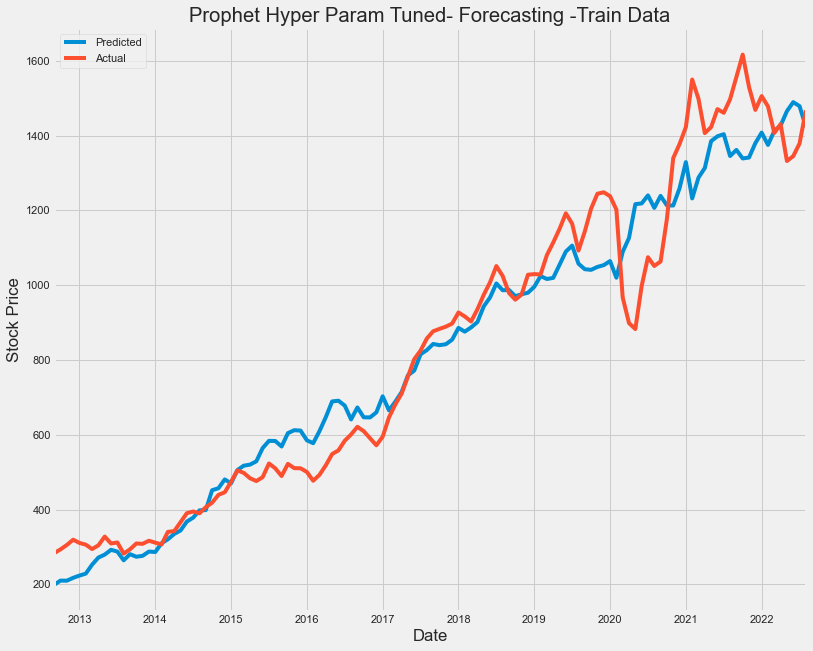

In [722]:
fig = plt.figure(figsize=(12,10))
prophet_hyper_df['Predicted'][:200].plot(label='Predicted')
prophet_hyper_df['Actual'][:200].plot(label='Actual')
plt.title('Prophet Hyper Param Tuned- Forecasting -Train Data')
plt.ylabel('Stock Price')
plt.legend()

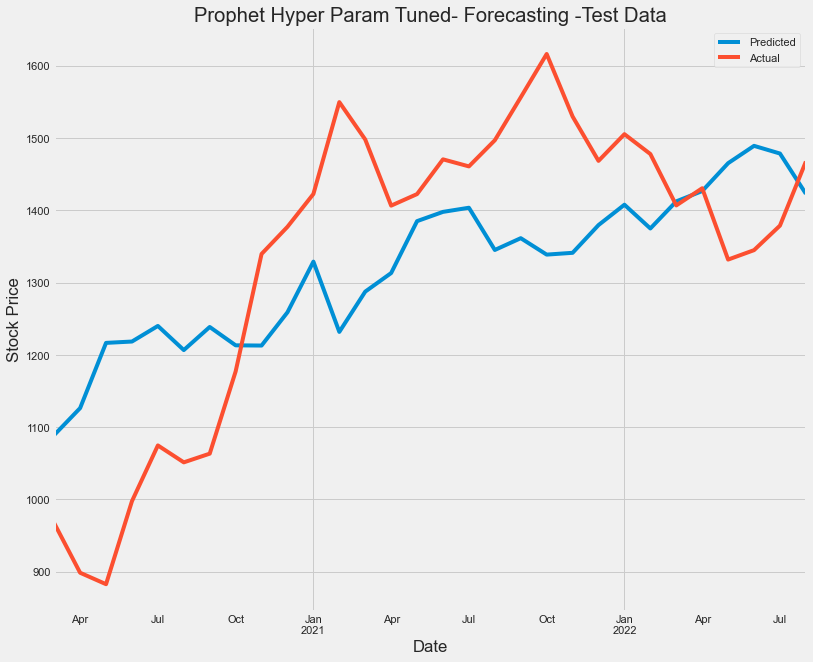

In [718]:
fig = plt.figure(figsize=(12,10))
prophet_hyper_df['Predicted'][90:].plot(label='Predicted')
prophet_hyper_df['Actual'][90:].plot(label='Actual')
plt.title('Prophet Hyper Param Tuned- Forecasting -Test Data')
plt.ylabel('Stock Price')
plt.legend()

In [719]:
result_metrics(prophet_hyper_df['Actual'][:67],prophet_hyper_df['Predicted'][:67],'Hyper-Tuned Prophet Train Data')

Result Metrics for Hyper-Tuned Prophet Train Data
R2 Score :  0.899
Mean Squared Error :  3729.835
Mean Absolute Error :  48.887


In [720]:
result_metrics(prophet_hyper_df['Actual'][67:],prophet_hyper_df['Predicted'][67:],'Hyper-Tuned Prophet Test Data')

Result Metrics for Hyper-Tuned Prophet Test Data
R2 Score :  0.574
Mean Squared Error :  18690.175
Mean Absolute Error :  110.44


After Hyper-parameter tuning the model is not able to capture the seasonality and sudden jump in time series in the Year 2017 onwards.

->Prophet is easily overfitted.

->Seasonal ARIMA is superior to Prophet

->Prophet is good at capturing the trend.

->By creating Extra Regressors we can maybe improve the Results in future projects.


### Project Summary

Seasonal ARIMA Vs Facebook's Prophet

->Advantages of Prophet includes very easy to implement, fast , and less statistical know-how model . In Seasonal ARIMA we had to follow lot of tests and process to generate predictions.

->Prophet has a overfitting problem .

->Overall Both models are robust .

->Prophet is better at dealing with outliers.

### Actionable Insight

Observing the Trend given by Both Models.

HDFCBANK IS A BUY.
